# GMAC Optimization: Grid search of GMAC parameters

The GMAC algorithm has the following parameters required to map the raw acceleration
data to the arm-use space. These parameters are:
1. Pitch angle threshold. $\left( \theta_{th} \right)$
2. Acceleration magnitude threshold. $\left( a_{th} \right)$

### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib
import itertools
import glob

In [3]:
import seaborn as sns

In [107]:
from matplotlib.ticker import MaxNLocator

### Custom Modules

In [4]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc

In [5]:
import gmac

In [6]:
# Define the font family and size
# font = {'family': 'sans-serif', 'sans-serif': ['Helvetica']}

# # Set the font properties for various elements
# plt.rc('font', **font)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight
# plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})


## Define notebook level constants

In [7]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)

## Read the Controls and Patients Data

In [8]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

# All limbs data ddf
datadf = {
    "left": left,
    "right": right,
    "aff": aff,
    "unaff": unaff
}

### Functions implementing the GMAC algorithm

In [9]:
# Generate all possible combinations of parameters.
def generate_param_combinations(param_ranges: dict) -> dict:
    """
    Generate all possible combinations of parameters.
    """
    for _np in param_ranges["np"]:
        for _fc in param_ranges["fc"]:
            for _nc in param_ranges["nc"]:
                for _nam in param_ranges["nam"]:
                    for _pth in param_ranges["p_th"]:
                        for _amth in param_ranges["am_th"]:
                            yield {
                                "np": int(_np),
                                "fc": _fc,
                                "nc": int(_nc),
                                "nam": int(_nam),
                                "p_th": _pth,
                                "am_th": _amth
                            }

In [10]:
def compute_confusion_matrix(actual: np.array, estimated: np.array) -> np.array:
    """
    Computes the components of the confusion matrix.
    """
    actual = np.array(actual, dtype=int)
    estimated = np.array(estimated, dtype=int)
    return {
        "TN": np.sum((actual + estimated) == 0), # TN
        "FP": np.sum((1 - actual + estimated) == 2), # FP
        "FN": np.sum((actual + 1 - estimated) == 2), # FN
        "TP": np.sum((actual + estimated) == 2), # TP
    }

## Dual Threshold

In [11]:
# Generate all possible combinations of parameters.
def generate_param_combinations2(param_ranges: dict) -> dict:
    """
    Generate all possible combinations of parameters.
    """
    for _np in param_ranges["np"]:
        for _fc in param_ranges["fc"]:
            for _nc in param_ranges["nc"]:
                for _nam in param_ranges["nam"]:
                    for _pth in param_ranges["p_th"]:
                        for _pthb in param_ranges["p_th_band"]:
                            for _amth in param_ranges["am_th"]:
                                for _amthb in param_ranges["am_th_band"]:
                                    yield {
                                        "np": int(_np),
                                        "fc": _fc,
                                        "nc": int(_nc),
                                        "nam": int(_nam),
                                        "p_th": _pth,
                                        "p_th_band": _pthb,
                                        "am_th": _amth,
                                        "am_th_band": _amthb
                                    }

#### Parameter ranges for the grid search

In [12]:
basedir = "../data/output-new"

# GMAC Parameter ranges
am_param_ranges = {
    "np": [int(Fs // 2)],
    "fc": [0.1],
    "nc": [2],
    "nam": [int(5*Fs)],
    "p_th": np.arange(-90, 90, 10),
    "p_th_band": np.arange(0, 80, 20),
    "am_th": [-1, 0, 0.01, 0.05, 0.1, 0.25, 0.5, 1.0],
    "am_th_band": [0, 0.01, 0.05, 0.1]
}

In [ ]:
for limbkey in ["left", "right", "aff", "unaff"]:
    # Make directory if it does not exist
    outdir = pathlib.Path(basedir, limbkey, "gmac2")
    outdir.mkdir(parents=True, exist_ok=True)

    # Which limb?
    limbdf = datadf[limbkey]
    subjects = limbdf.subject.unique()

    # Estimate pitch for each subject.
    accl_cols = ['ax', 'ay', 'az']
    dfcols = (["subject"] + list(am_param_ranges.keys()) +
              ["TN", "FP", "FN", "TP"] +
              ["TNr", "FPr", "FNr", "TPr"] +
              ["sensitivity", "specificity", "youden"])

    # Number of all possible combinations
    Ncombs = len(list(generate_param_combinations2(am_param_ranges)))

    # All parameter combinations.
    param_combs = list(generate_param_combinations2(am_param_ranges))

    gmac_perf_df = pd.DataFrame(columns=dfcols)
    for i, subj in enumerate(subjects):
        # Go through all parameter combinations.
        _sinx = limbdf.subject == subj
        for j, _pc in enumerate(param_combs):
            sys.stdout.write(f"\r{limbkey} {i:3d}, {j:3d}")
            df = limbdf[limbdf.subject==subj]
            # Compute gmac
            _gmac = np.hstack([
                gmac.estimate_gmac2(_df[accl_cols].values, accl_farm_inx=0, Fs=Fs,
                                    params=_pc)
                for _, _df in df.groupby('segment')
            ])
            # Compute performance
            _perf = compute_confusion_matrix(actual=df.gnd.values, estimated=_gmac)
            
            # Update gmac df
            _rowdf = pd.DataFrame({"subject": subj} | _pc | _perf, index=[0])
            _rowdf[["TNr", "FPr", "FNr", "TPr"]] = _rowdf[["TN", "FP", "FN", "TP"]] / np.sum(_rowdf[["TN", "FP", "FN", "TP"]].values)
            _rowdf["sensitivity"] = _rowdf.TP / (_rowdf.TP + _rowdf.FN)
            _rowdf["specificity"] = _rowdf.TN / (_rowdf.TN + _rowdf.FP)
            _rowdf["youden"] = _rowdf.sensitivity + _rowdf.specificity - 1
            gmac_perf_df = pd.concat(
                (gmac_perf_df, _rowdf),
                ignore_index=True
            )
    # Save data
    gmac_perf_df.to_csv(pathlib.Path(basedir, limbkey, "gmac2", f"gmac2.csv").as_posix(), index=False)


In [13]:
# Read and combine data from different subjects in one file.
_path = pathlib.Path(basedir, "left", "am").as_posix() + "/*-am.csv"
gmac_perf_df = {
    _lmb: pd.read_csv(pathlib.Path(basedir, _lmb, "gmac2", "gmac2.csv").as_posix())
    for _lmb in ["left", "right", "aff", "unaff"]
}

### Summary Plots

In [103]:
# Get performance for the different parameters combinations.
perf = np.zeros((len(am_param_ranges["am_th"]),
                 len(am_param_ranges["p_th"]),
                 len(am_param_ranges["p_th_band"])))
med = np.zeros((len(am_param_ranges["am_th"]),
                len(am_param_ranges["p_th"]),
                len(am_param_ranges["p_th_band"])))
iqr = np.zeros((len(am_param_ranges["am_th"]),
                len(am_param_ranges["p_th"]),
                len(am_param_ranges["p_th_band"])))
limbs = ["left", "right", "aff", "unaff"]
for i, _amth in enumerate(am_param_ranges["am_th"]):
    for j, _pth in enumerate(am_param_ranges["p_th"]):
        for k, _pthb in enumerate(am_param_ranges["p_th_band"]):
            # Go through all limbs
            _vals = []
            for l, _lmb in enumerate(limbs):
                _inx = ((gmac_perf_df[_lmb].am_th == _amth) &
                        (gmac_perf_df[_lmb].am_th_band == 0) &
                        (gmac_perf_df[_lmb].p_th == _pth) &
                        (gmac_perf_df[_lmb].p_th_band == _pthb))
                _vals.append(gmac_perf_df[_lmb].loc[_inx, "youden"].values)
                sys.stdout.write(f"\r{i, j, k} ")
            # Compute the cost.
            _vals = np.hstack(_vals)
            # Computer performance
            _perfs = [np.percentile(_vals, q) for q in [25, 50, 75]]
            perf[i, j, k] = _perfs[1] * (1 - (_perfs[2] - _perfs[0]))
            med[i, j, k] = _perfs[1]
            iqr[i, j, k] = _perfs[2] - _perfs[0]

(7, 17, 3) 

In [198]:
# Find maximum performance
_perf = perf[:, ::-1, :]
maxinx = np.where(_perf == np.max(_perf))
bestarg = np.array([am_param_ranges["am_th"][maxinx[0][0]],
                    am_param_ranges["p_th"][::-1][maxinx[1][0]],
                    am_param_ranges["p_th_band"][maxinx[2][0]]])
bestarg

array([ 0.1, 10. , 40. ])

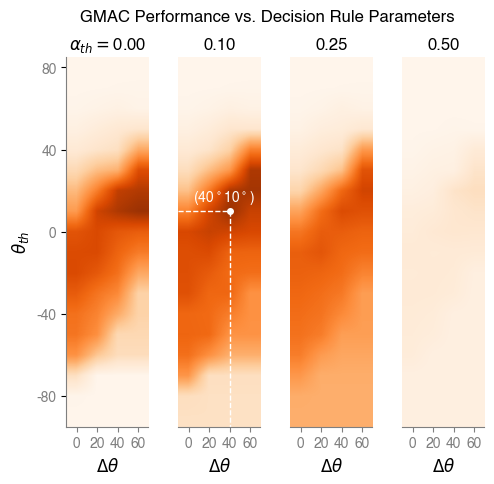

In [216]:
fig = plt.figure()
showinx = [1, 4, 5, 6]
for i, j in enumerate(showinx):
    _amth = am_param_ranges["am_th"][j]
    ax = fig.add_subplot(1, len(showinx), i+1)
    # Create the heatmap using imshow
    ax.imshow(perf[j][::-1,:], cmap='Oranges', interpolation='bilinear',
              vmin=0, vmax=0.4)
    if i == 0:
        ax.set_ylabel(r'$\theta_{th}$', fontsize=12)
        ax.set_yticks(np.arange(perf[0].shape[0]),
                      labels=am_param_ranges["p_th"][::-1],
                      color="tab:gray")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
        ax.spines["left"].set_visible(True)
        ax.spines["left"].set_color("tab:gray")
    else:
        ax.set_yticks([])
        ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_color("tab:gray")

    # Set x ticks
    ax.set_xticks(np.arange(perf[0].shape[1]),
                  labels=am_param_ranges["p_th_band"],
                  color="tab:gray")

    # Add labels to the axes
    ax.set_xlabel(r'$\Delta\theta$', fontsize=12)
    ax.xaxis.set_tick_params(color='tab:grey')

    # Plot the max. point.
    if j == maxinx[0][0]:
        ax.plot(maxinx[2][0], maxinx[1][0], 'o', color='white', markersize=4)
        ax.plot([maxinx[2][0], maxinx[2][0]],
                [maxinx[1][0], len(am_param_ranges["p_th"]) - 0.5], lw=1,
                ls='--', color='white')
        ax.plot([-0.5, maxinx[2][0]],
                [maxinx[1][0], maxinx[1][0]], lw=1,
                ls='--', color='white')
        # Show the max. argument
        ax.text(maxinx[2][0] - 0.25, maxinx[1][0] - 0.25,
                (f"({bestarg[2]:0.0f}"
                 + r"$^\circ$" 
                 + f"{bestarg[1]:0.0f}"
                 + r"$^\circ$)"),
                color='white', ha='center', va='bottom',
                fontsize=10)

    # Set the plot title
    if i == 0:
        ax.set_title(r'$\alpha_{th} = $' + f"{_amth:0.2f}")
    else:
        ax.set_title(f"{_amth:0.2f}")

plt.suptitle("GMAC Performance vs. Decision Rule Parameters")
plt.subplots_adjust(wspace=-0.3)

# Save plot
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm.svg"), bbox_inches="tight")

0.36278842355743773


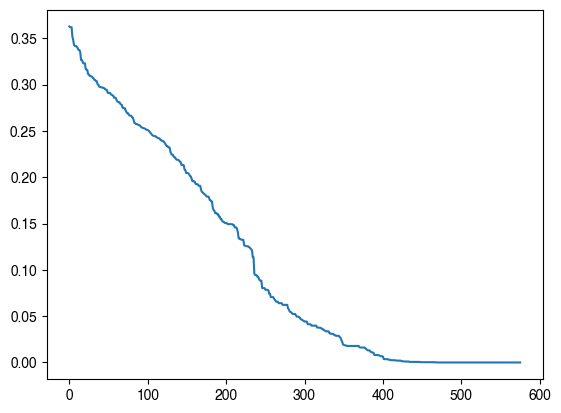

In [235]:
# Max. value of performance.
print(np.max(perf))

plt.plot(np.sort(perf.flatten())[::-1])

In [239]:
_inxs = np.array(np.where(perf > 0.99 * np.max(perf)))
for _ix in _inxs.T:
    print(am_param_ranges["am_th"][_ix[0]],
            am_param_ranges["p_th"][_ix[1]],
            am_param_ranges["p_th_band"][_ix[2]])

-1 10 60
0 10 60
0.01 10 60
0.1 10 40


In [102]:
(am_param_ranges["am_th"][maxinx[0][0]],
 am_param_ranges["p_th"][maxinx[1][0]],
 am_param_ranges["p_th_band"][maxinx[2][0]])

(0.1, 10, 40)

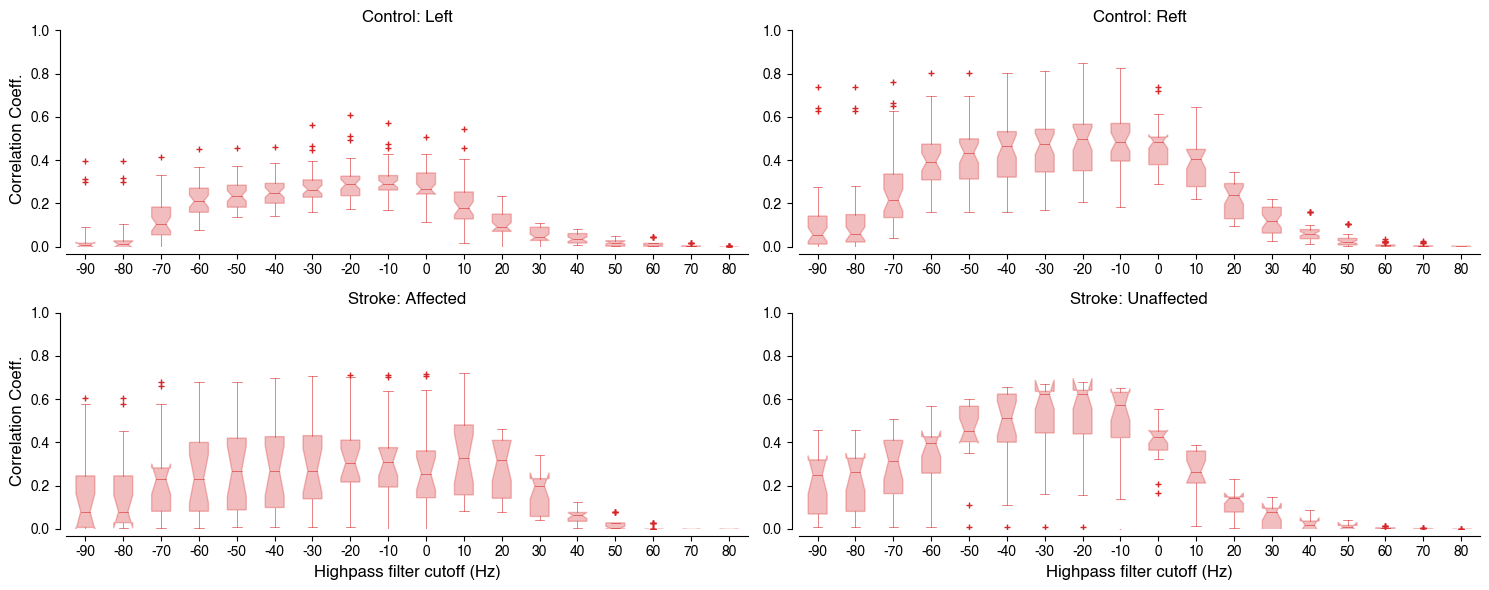

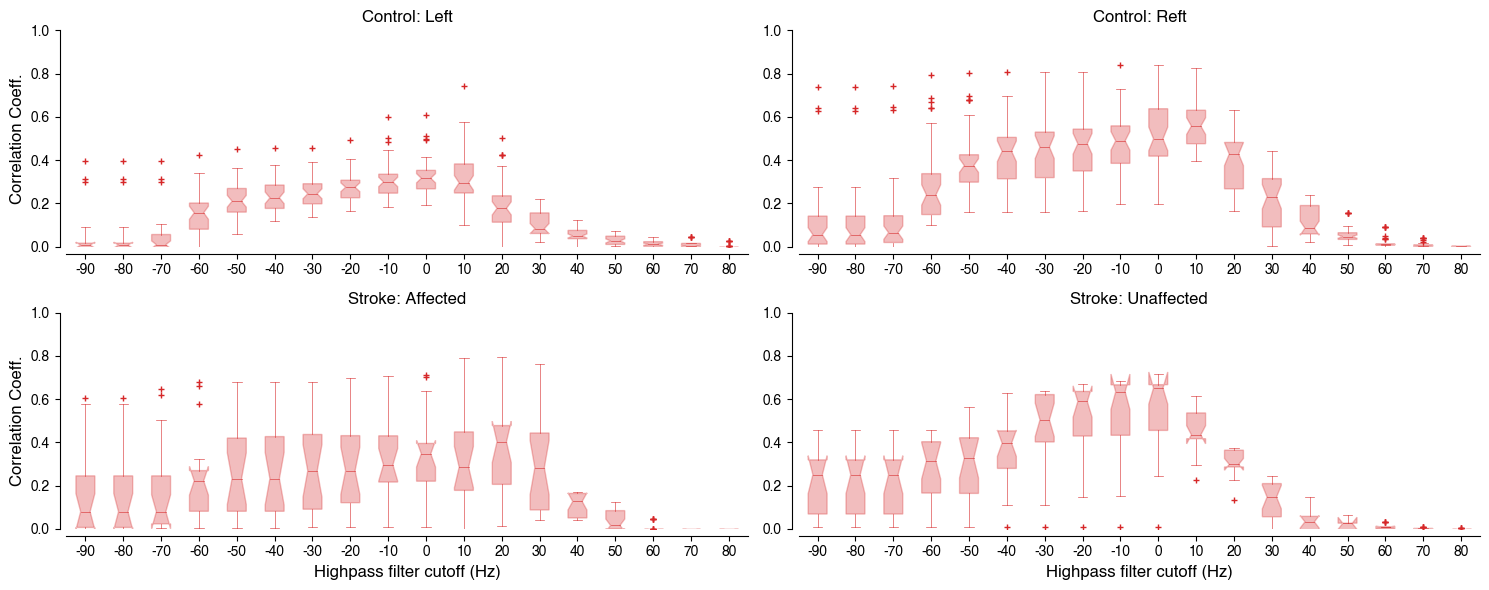

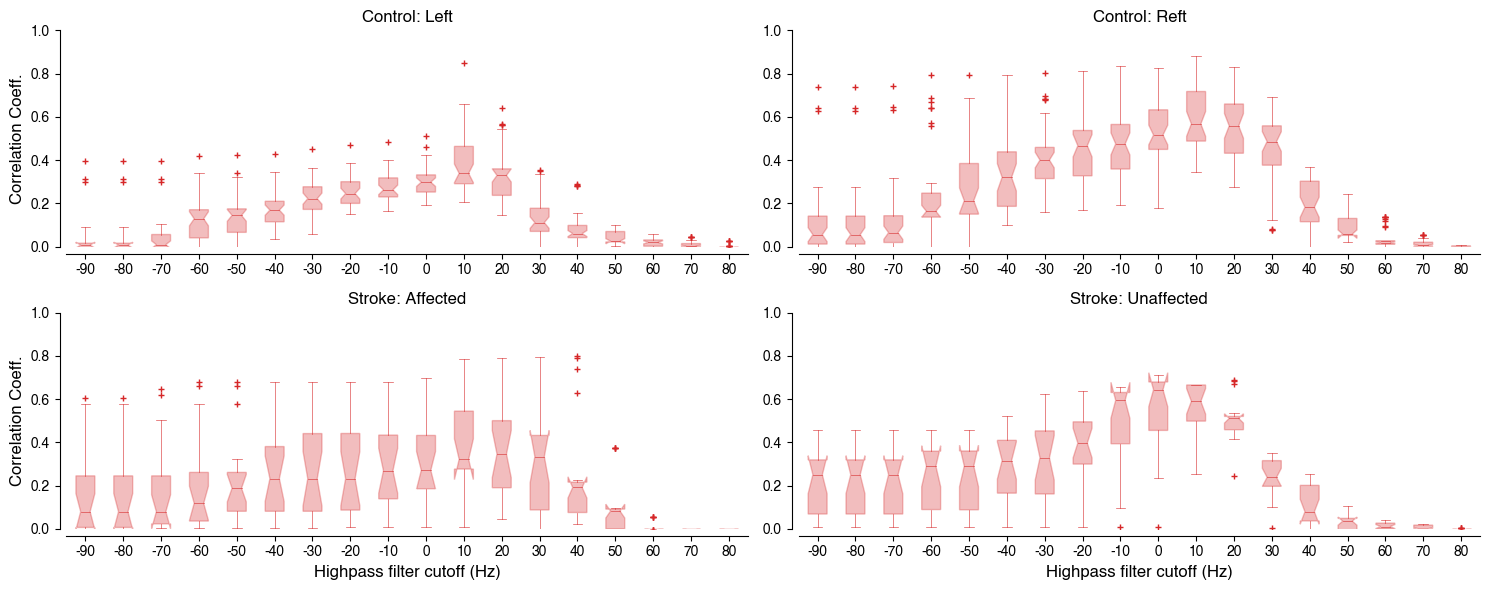

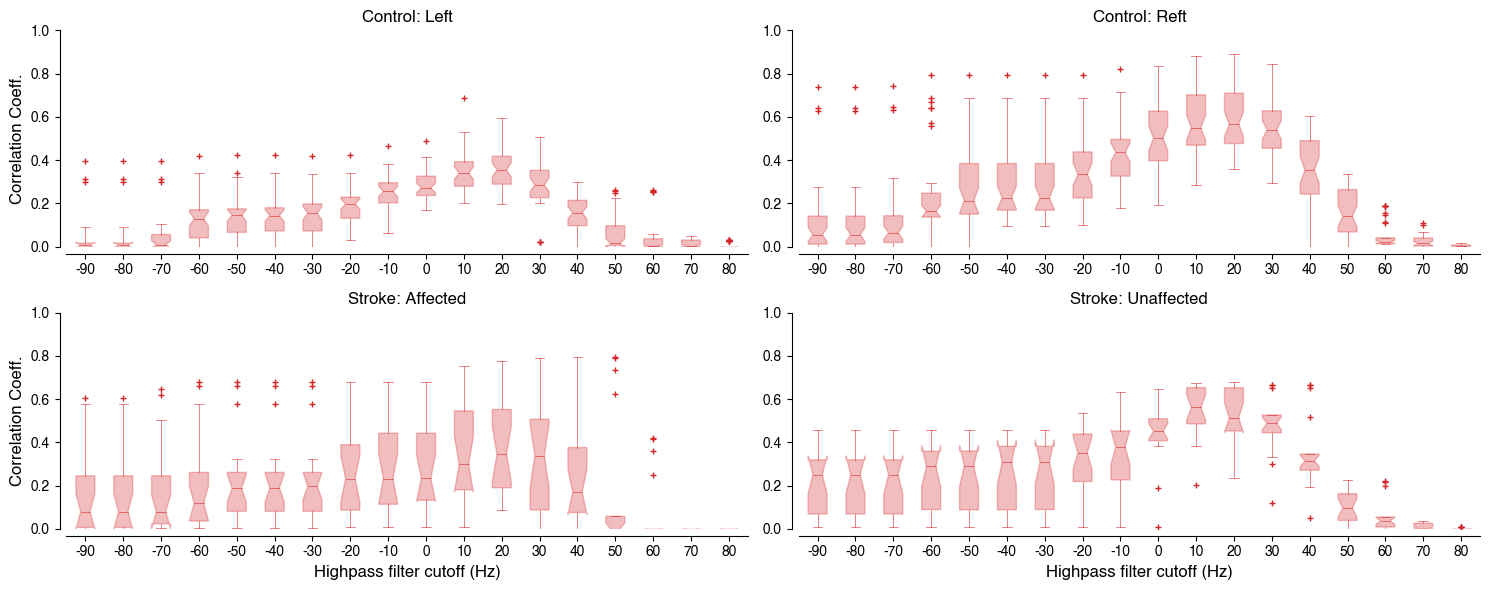

In [14]:
# Effect of pitch threshold.
am_th = 0.1
for j, _pthbval in enumerate(am_param_ranges["p_th_band"]):
    fig = plt.figure(figsize=(15, 6))
    for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
        ax = fig.add_subplot(2, 2, j+1)
        for i, _pval in enumerate(am_param_ranges["p_th"]):
            _inx = ((gmac_perf_df[_lmb]["p_th"] == _pval) & 
                    (gmac_perf_df[_lmb]["p_th_band"] == _pthbval) & 
                    (gmac_perf_df[_lmb]["am_th"] == am_th))
            _yi = gmac_perf_df[_lmb][_inx]["youden"].values
            ax.boxplot(x=_yi, positions=[i],
                    widths=0.5, notch=True, patch_artist=True,
                    boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
                    capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                    whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                    flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                                    markerfacecolor='tab:red', marker='+', markersize=4),
                    medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
            ax.set_ylim(0.0, 1.0)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_position(('outward', 5))
            ax.spines['bottom'].set_position(('outward', 5))
            ax.set_title(f"{_lmb}", fontsize=12)
            if _lmb == "left":
                ax.set_title("Control: Left", fontsize=12)
            elif _lmb == "right":
                ax.set_title("Control: Reft", fontsize=12)
            elif _lmb == "aff":
                ax.set_title("Stroke: Affected", fontsize=12)
            else:
                ax.set_title("Stroke: Unaffected", fontsize=12)
            
            if j // 2 == 1:
                ax.set_xlabel("Highpass filter cutoff (Hz)", fontsize=12)
            if j % 2 == 0:
                ax.set_ylabel("Correlation Coeff.", fontsize=12)
        
        ax.set_xticklabels(am_param_ranges["p_th"])
    plt.tight_layout()

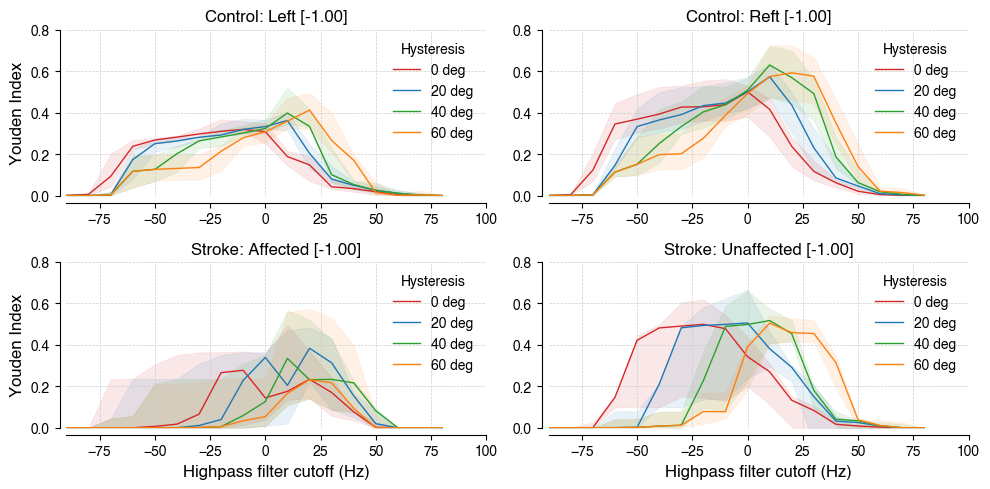

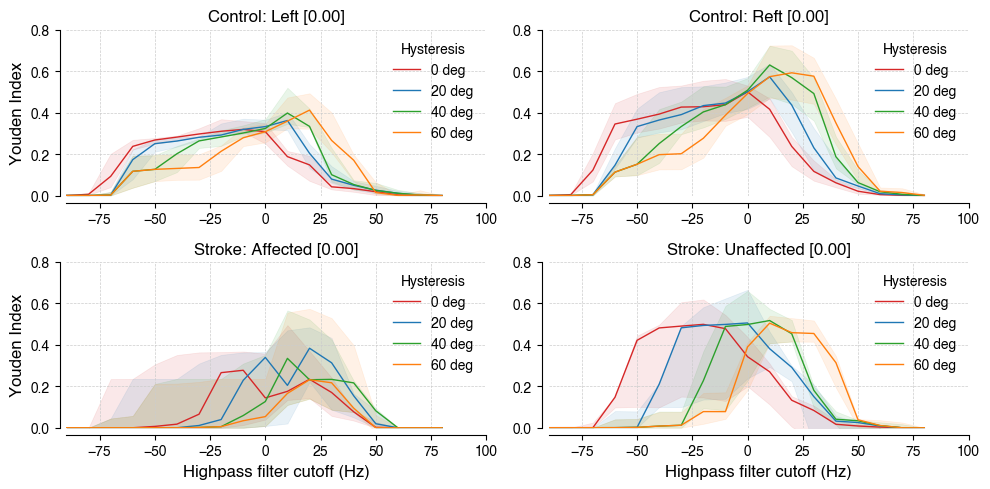

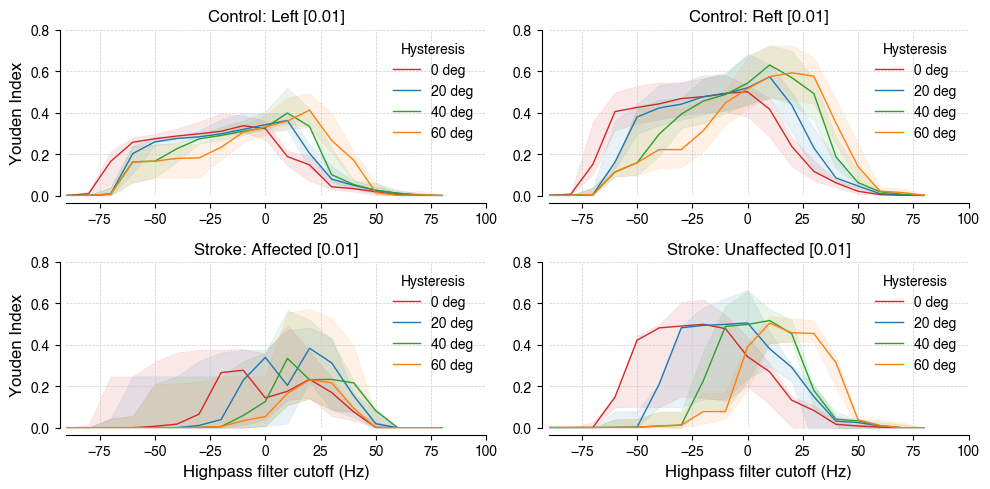

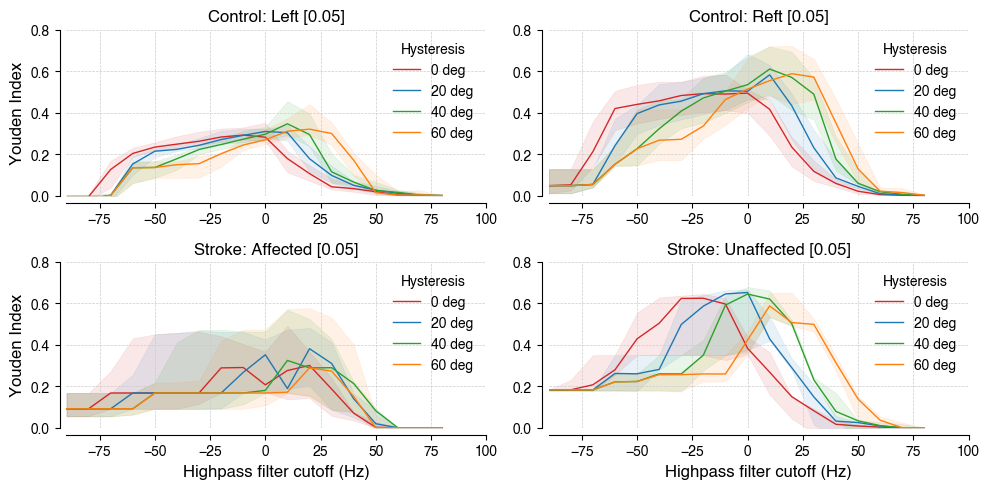

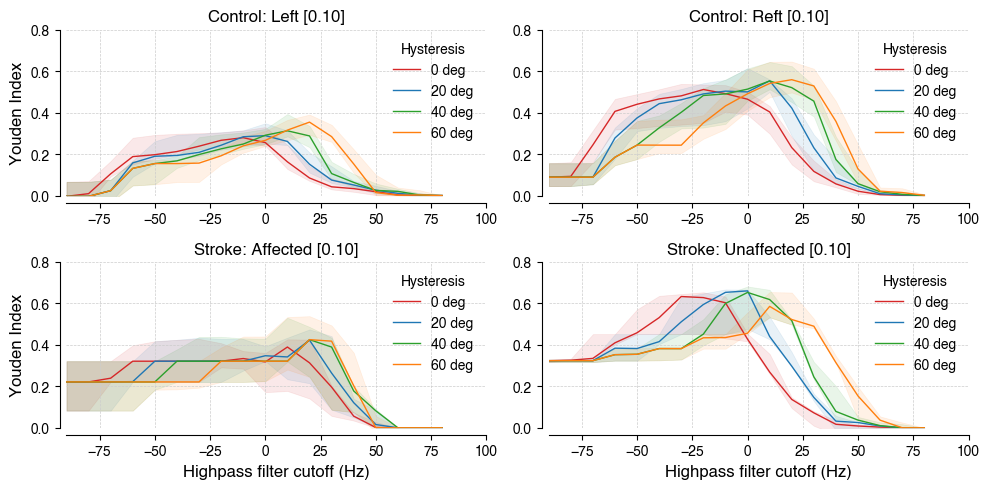

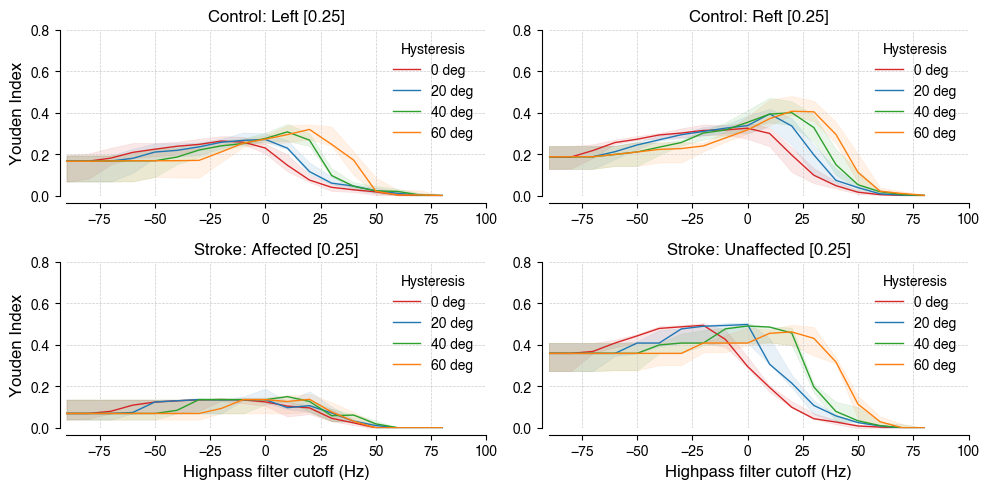

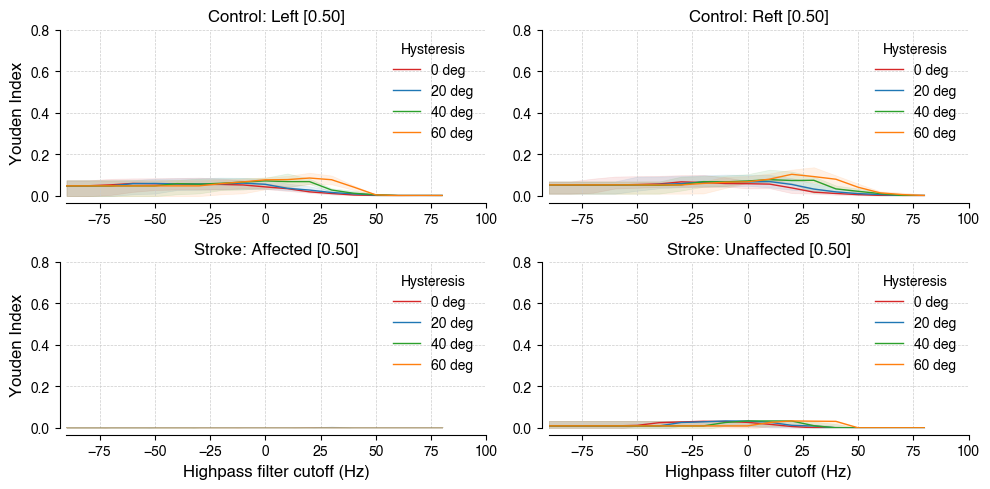

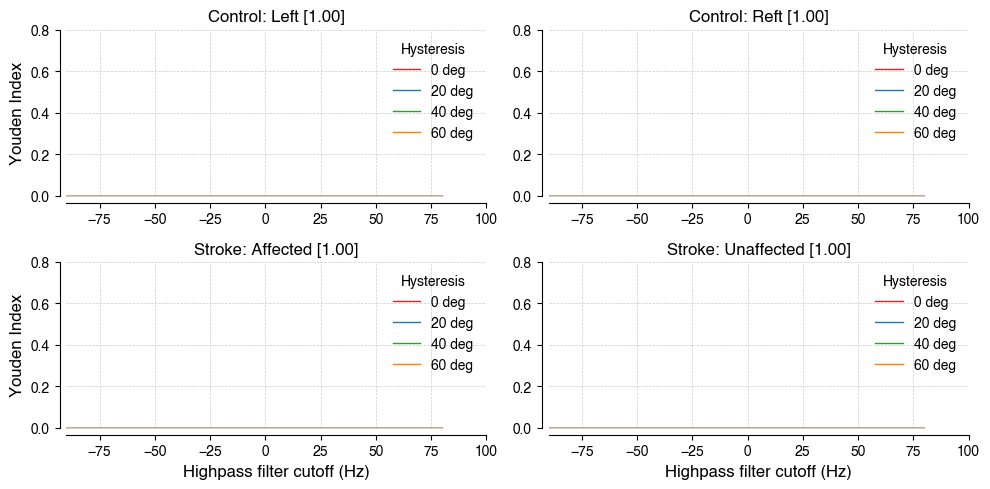

In [138]:
# Effect of pitch threshold.
for am_th in am_param_ranges["am_th"]:
    fig = plt.figure(figsize=(10, 5))
    colors = ["tab:red", "tab:blue", "tab:green", "tab:orange", "tab:purple"]
    for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
        ax = fig.add_subplot(2, 2, j+1)
        for k, _pthbval in enumerate(am_param_ranges["p_th_band"]):
            # if k % 2 != 0:
            #     continue
            _yivals = []
            for i, _pval in enumerate(am_param_ranges["p_th"]):
                _inx = ((gmac_perf_df[_lmb]["p_th"] == _pval) &
                        (gmac_perf_df[_lmb]["p_th_band"] == _pthbval) &
                        (gmac_perf_df[_lmb]["am_th"] == am_th) &
                        (gmac_perf_df[_lmb]["am_th_band"] == 0))
                _yi = gmac_perf_df[_lmb][_inx]["youden"].values
                _yivals.append(np.nanpercentile(_yi, [25, 50, 75]))
            
            # Plot values.
            _yivals = np.array(_yivals).astype(float)
            ax.plot(am_param_ranges["p_th"], _yivals[:, 1], color=colors[k], lw=1,
                    label=f"{_pthbval} deg")
            ax.fill_between(x=am_param_ranges["p_th"], y1=_yivals[:, 0],
                            y2=_yivals[:, 2], color=colors[k], lw=0.5, alpha=0.1)
            ax.set_ylim(0.0, 0.8)
            ax.set_xlim(-90, 100)
            ax.grid(color='0.8', linestyle='--', linewidth=0.5);
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_position(('outward', 5))
            ax.spines['bottom'].set_position(('outward', 5))
            ax.set_title(f"{_lmb}", fontsize=12)
            if _lmb == "left":
                ax.set_title(f"Control: Left [{am_th:0.2f}]", fontsize=12)
            elif _lmb == "right":
                ax.set_title(f"Control: Reft [{am_th:0.2f}]", fontsize=12)
            elif _lmb == "aff":
                ax.set_title(f"Stroke: Affected [{am_th:0.2f}]", fontsize=12)
            else:
                ax.set_title(f"Stroke: Unaffected [{am_th:0.2f}]", fontsize=12)
            
            if j // 2 == 1:
                ax.set_xlabel("Highpass filter cutoff (Hz)", fontsize=12)
            if j % 2 == 0:
                ax.set_ylabel("Youden Index", fontsize=12)
        _l = ax.legend(loc=1, fontsize=10, frameon=False)
        _l.set_title("Hysteresis")
    plt.tight_layout()
    fig.savefig(pathlib.Path(basedir, f"gmac_compare_ampth_{am_th:0.2f}.pdf"), bbox_inches="tight")
    fig.savefig(pathlib.Path(basedir, f"gmac_compare_ampth_{am_th:0.2f}.svg"), bbox_inches="tight")


/var/folders/b1/lv90qvk91r10v6yns5ws2lvc0000gn/T/ipykernel_5448/1797568333.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 5))


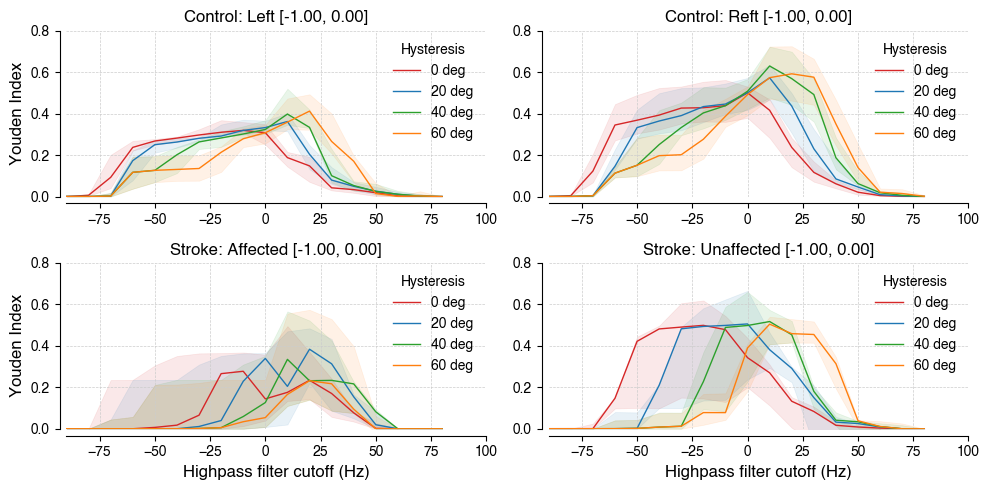

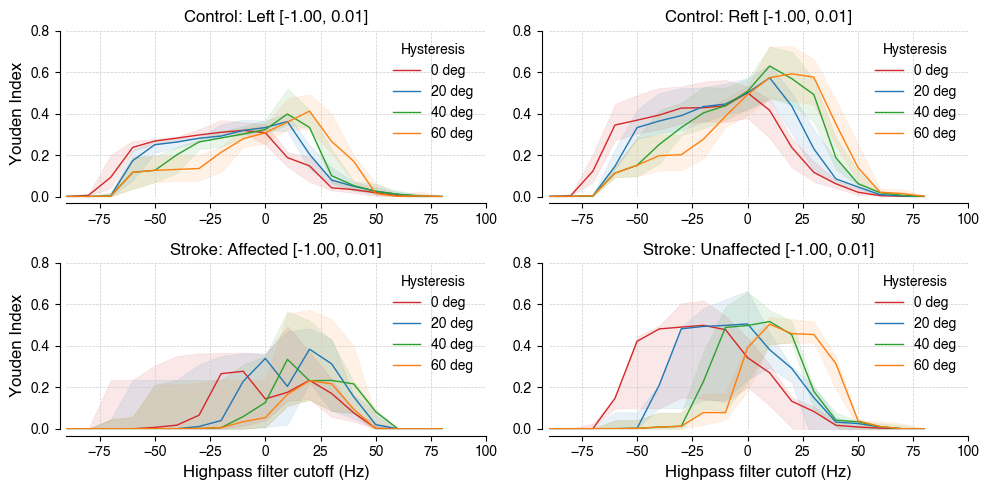

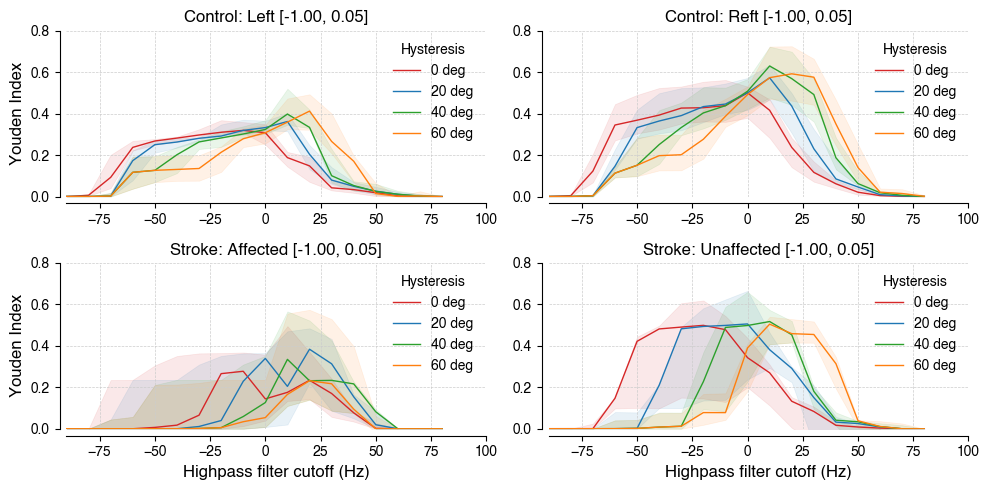

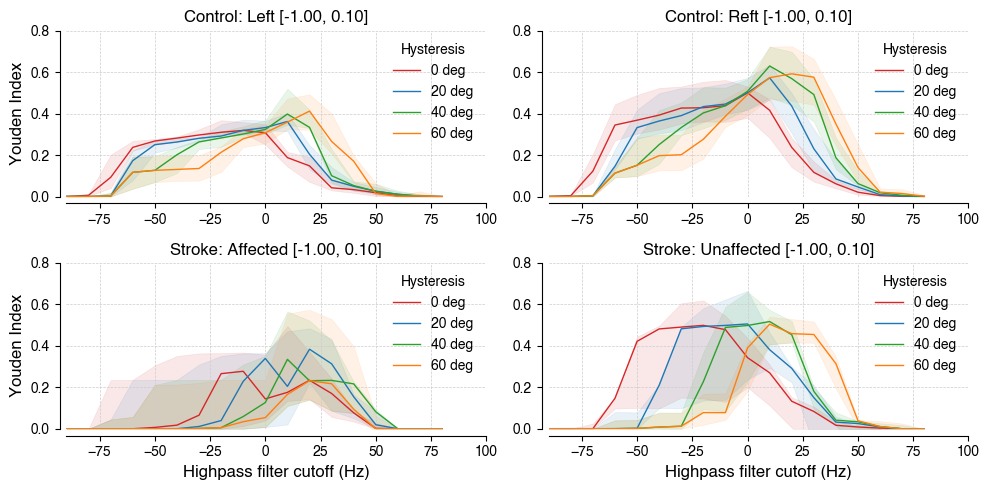

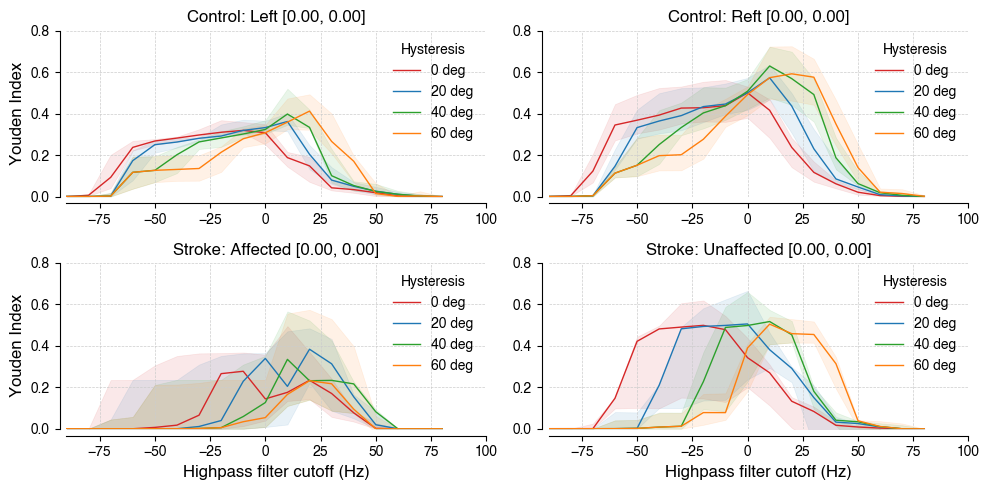

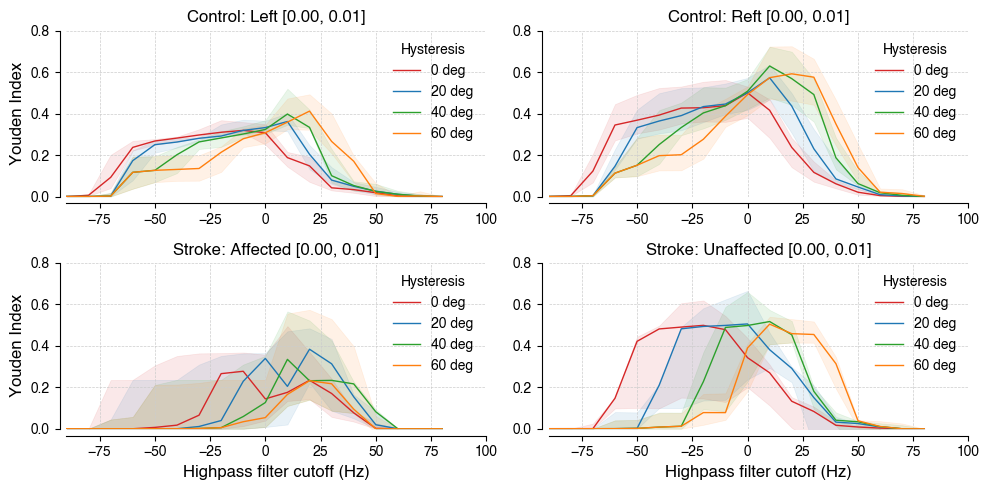

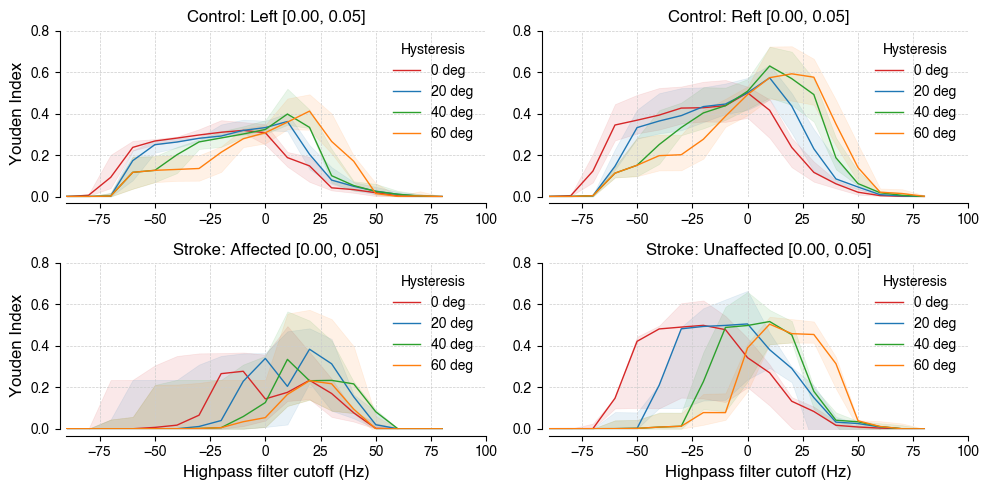

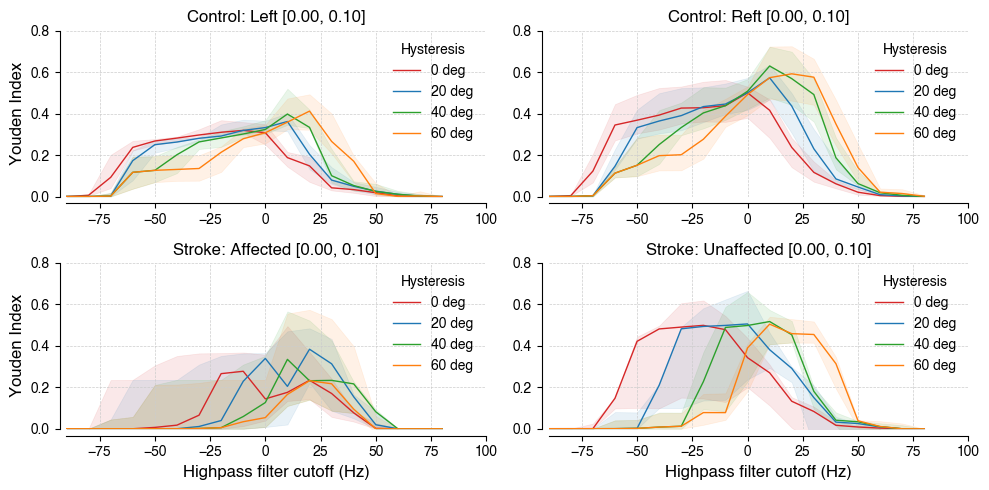

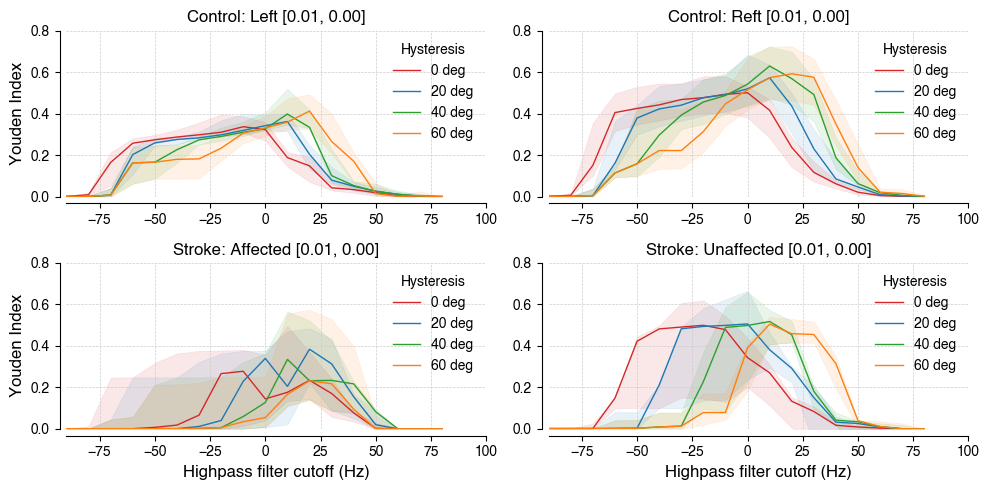

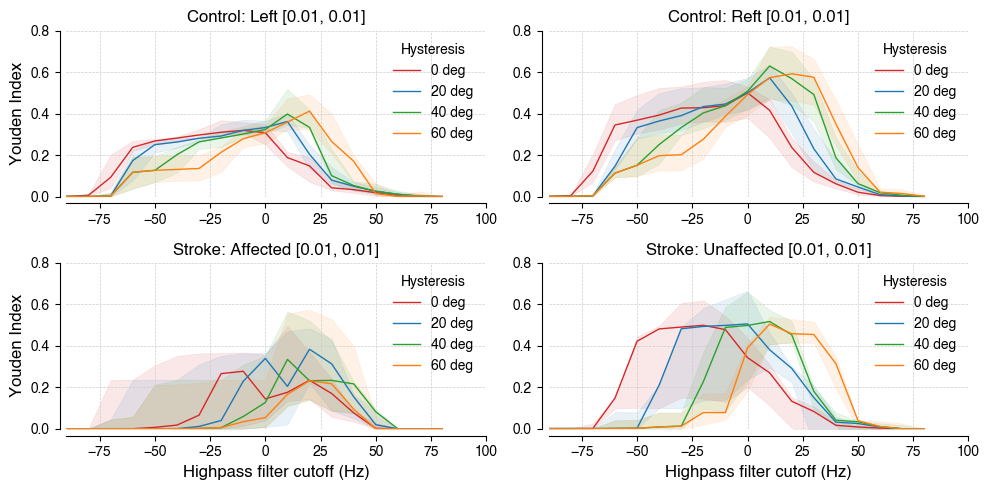

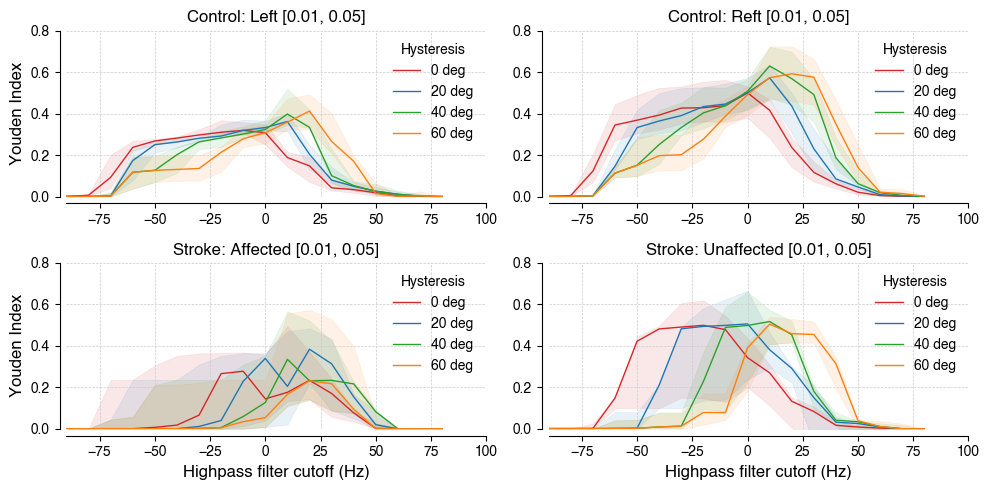

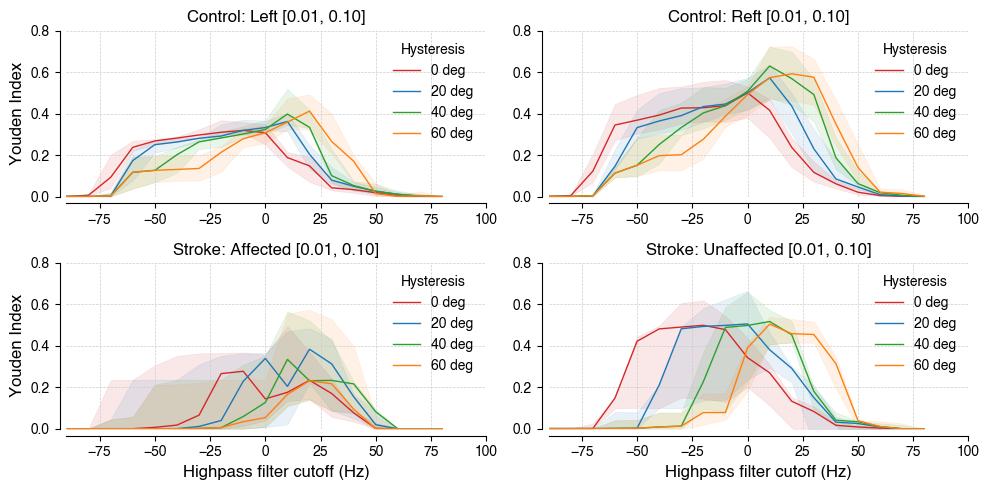

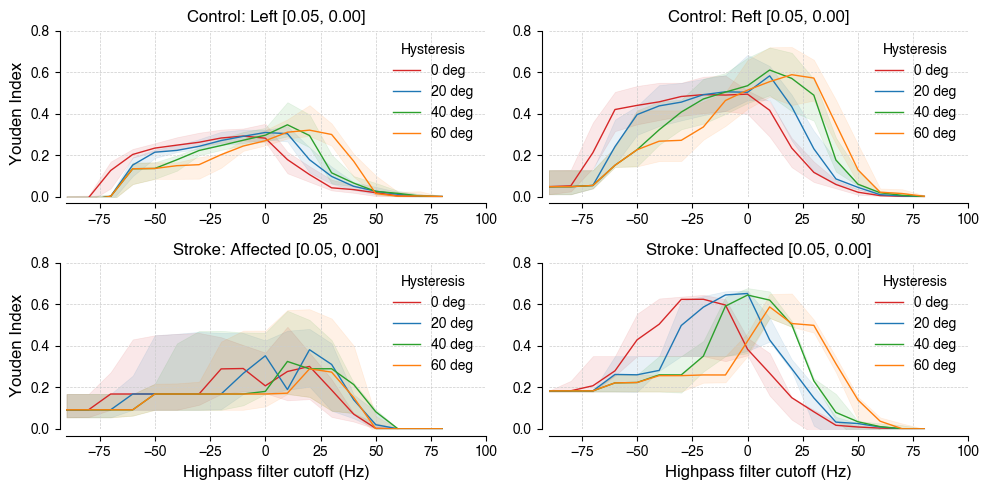

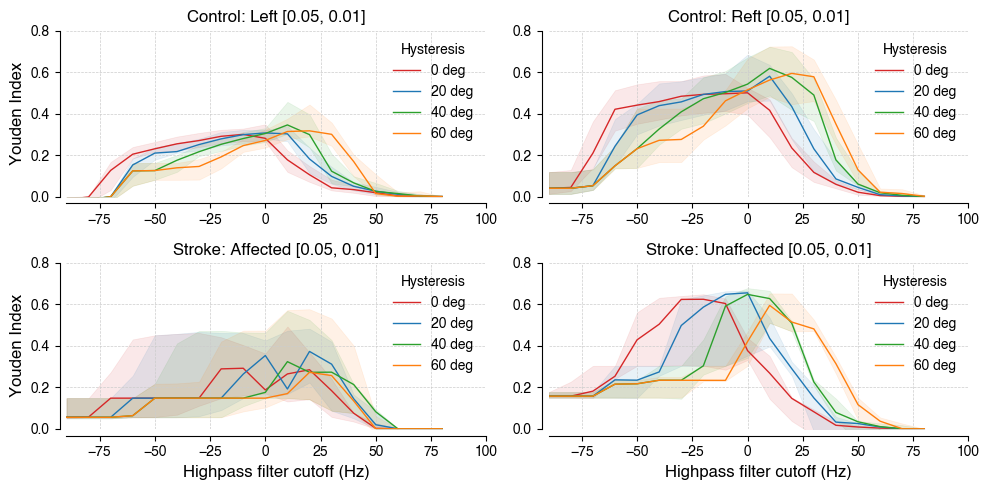

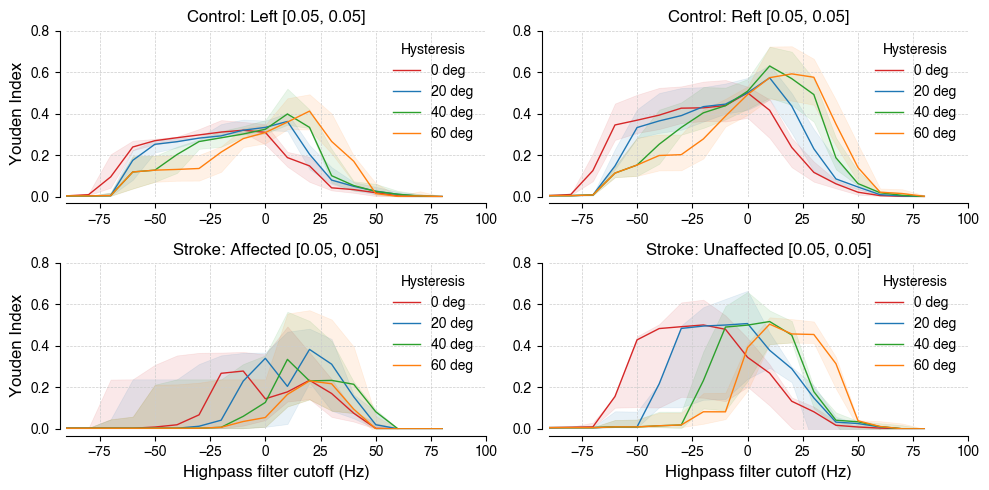

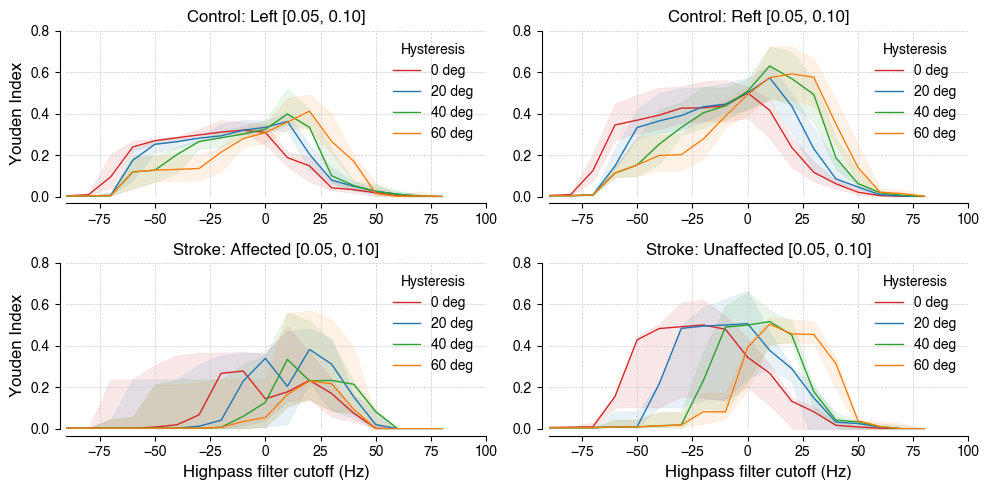

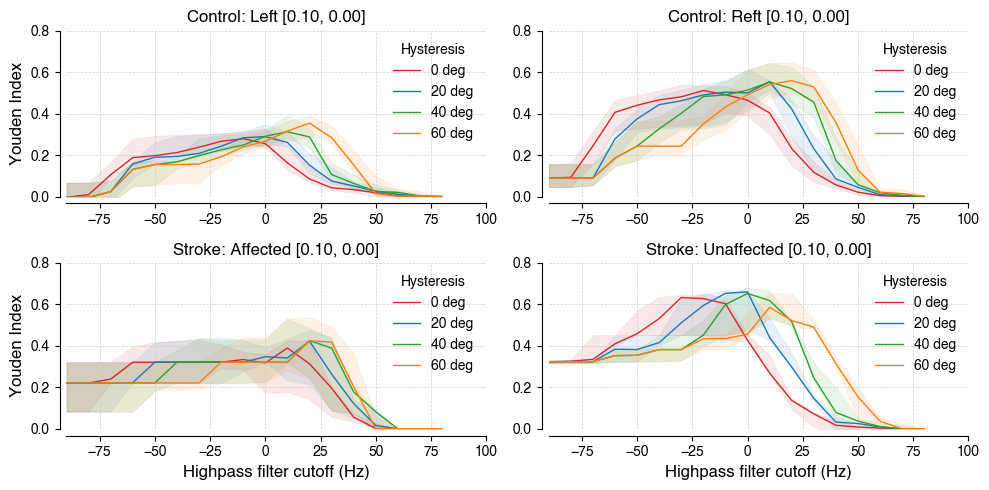

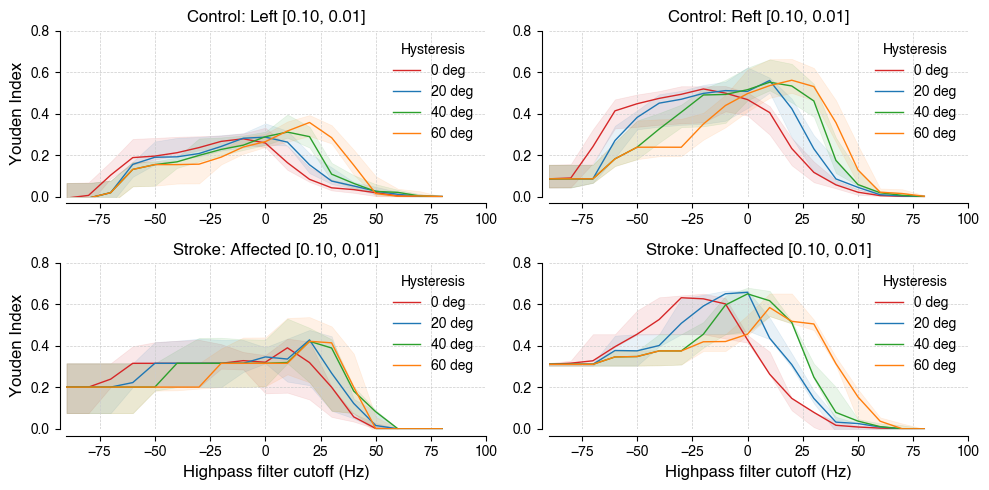

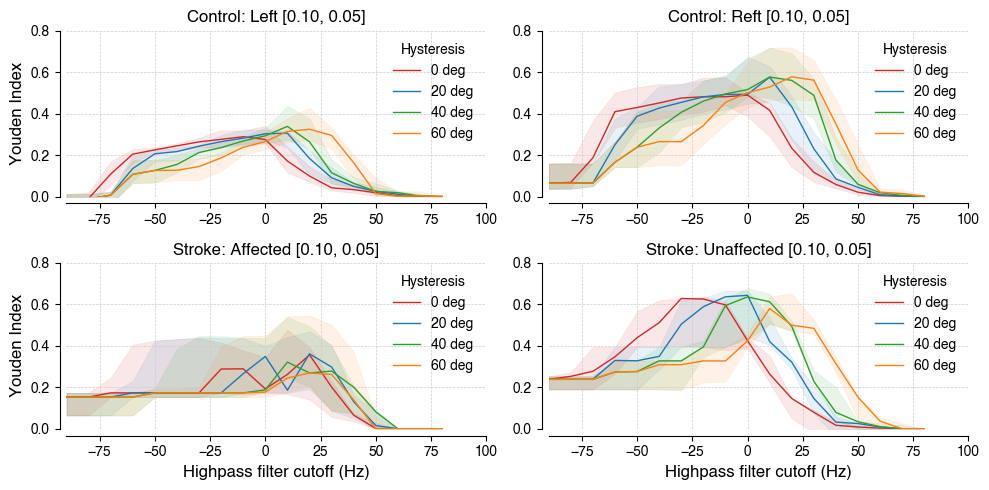

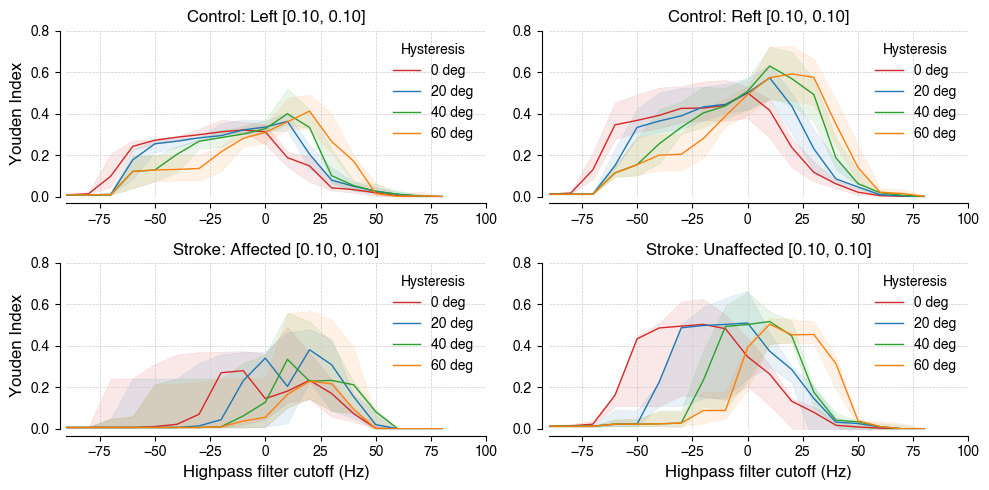

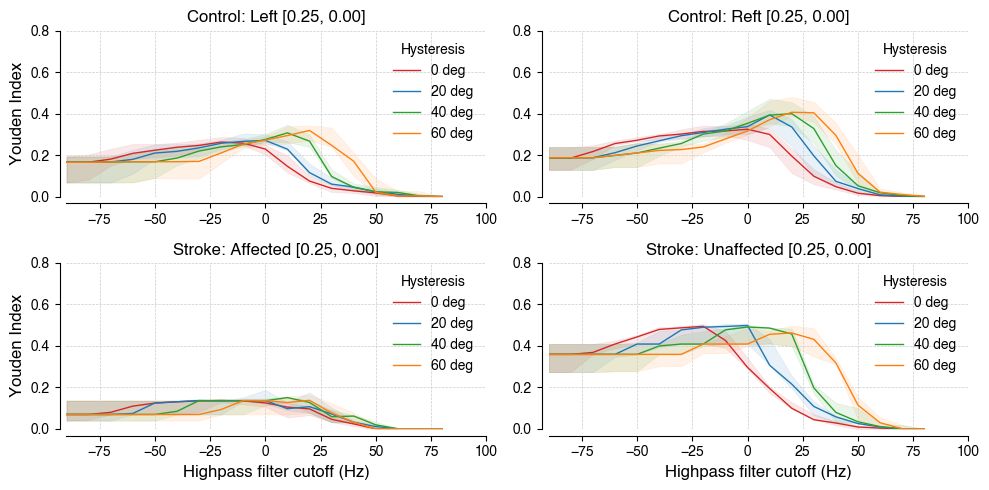

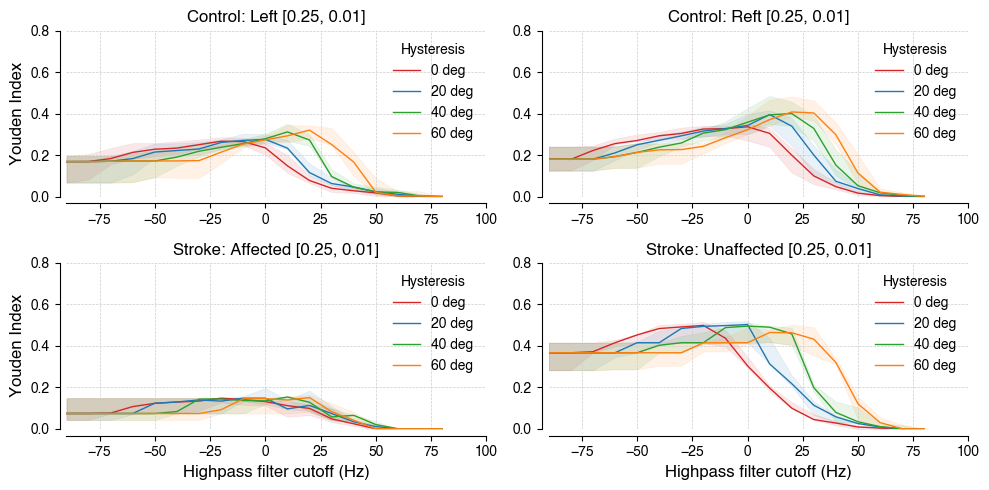

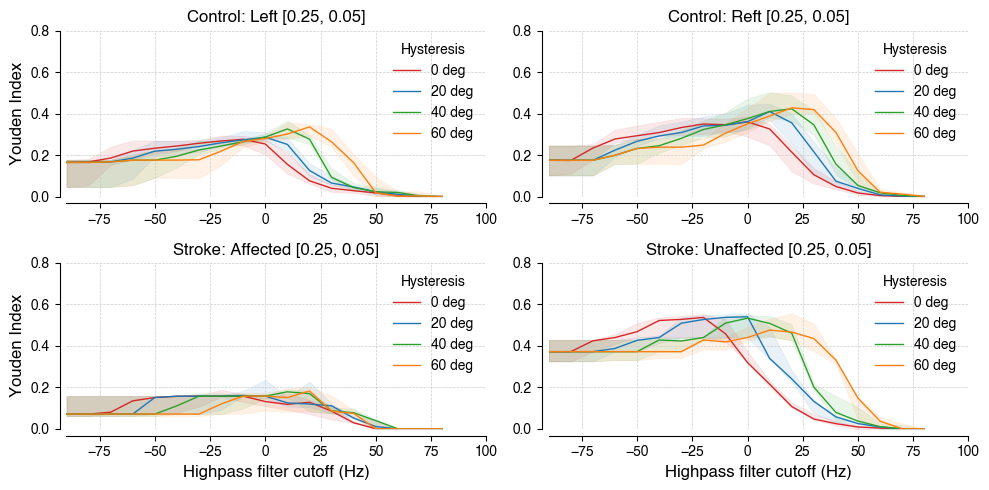

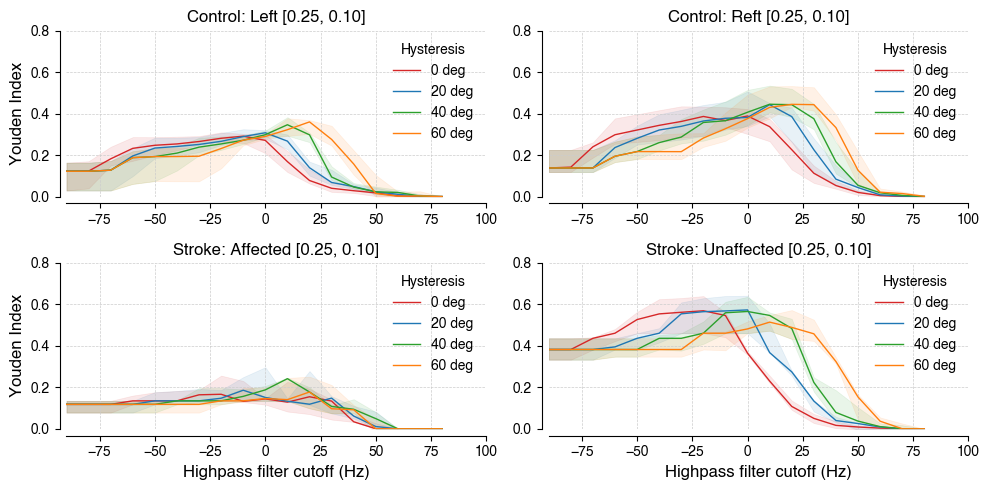

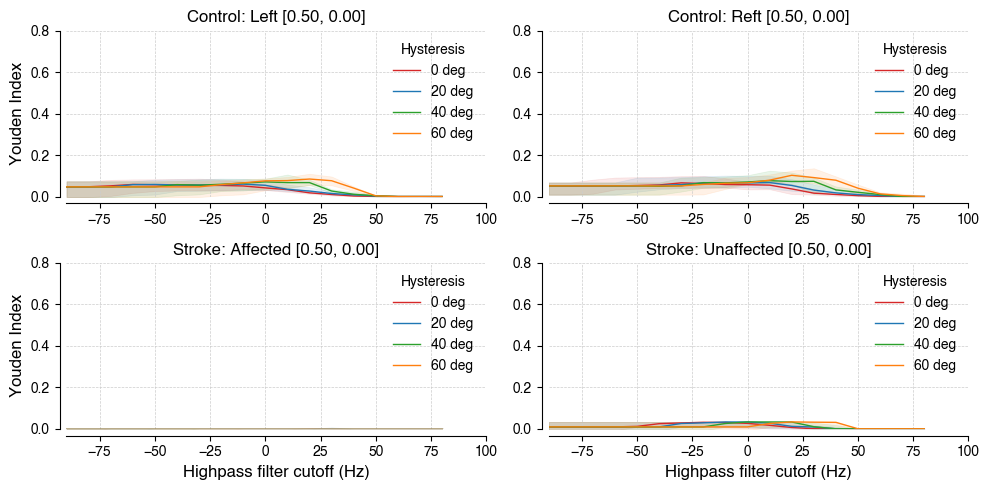

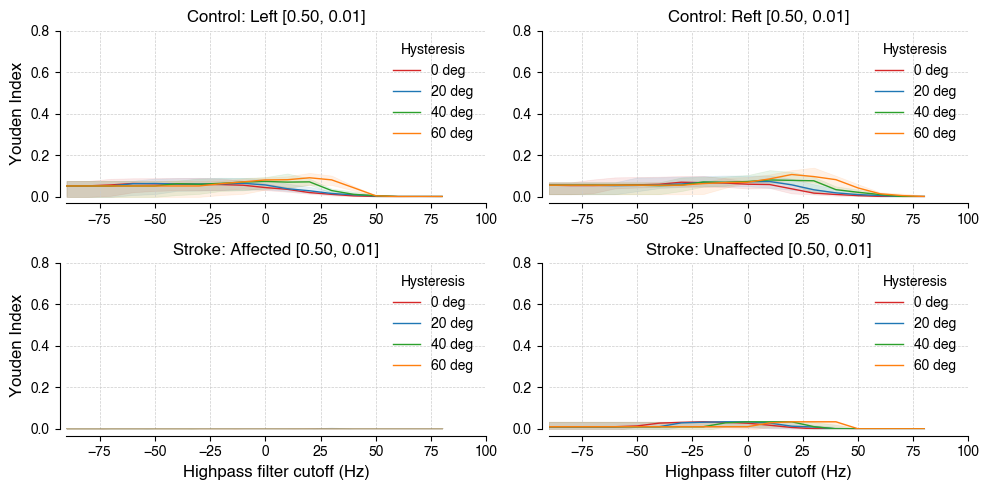

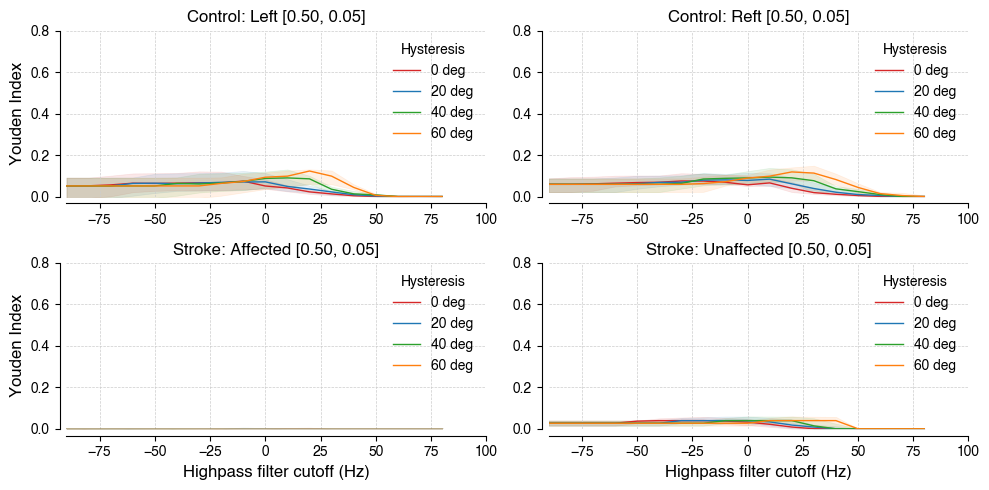

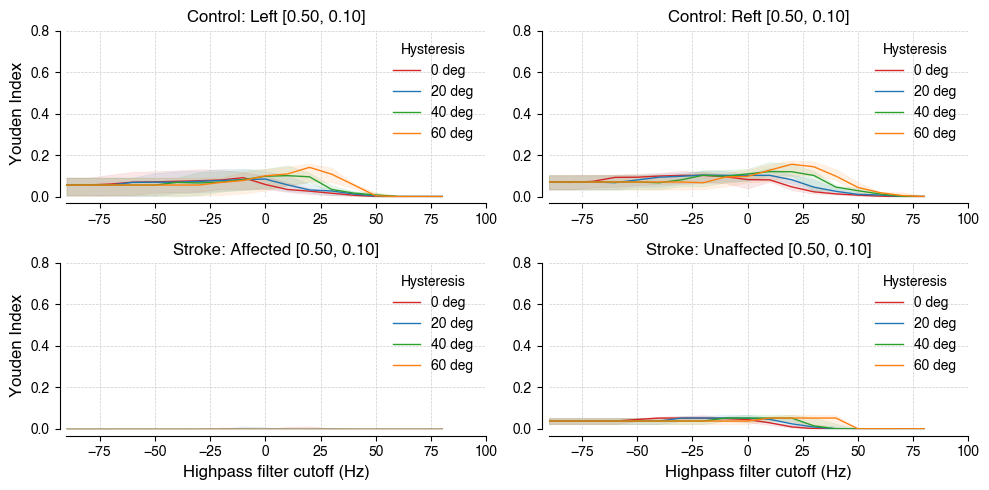

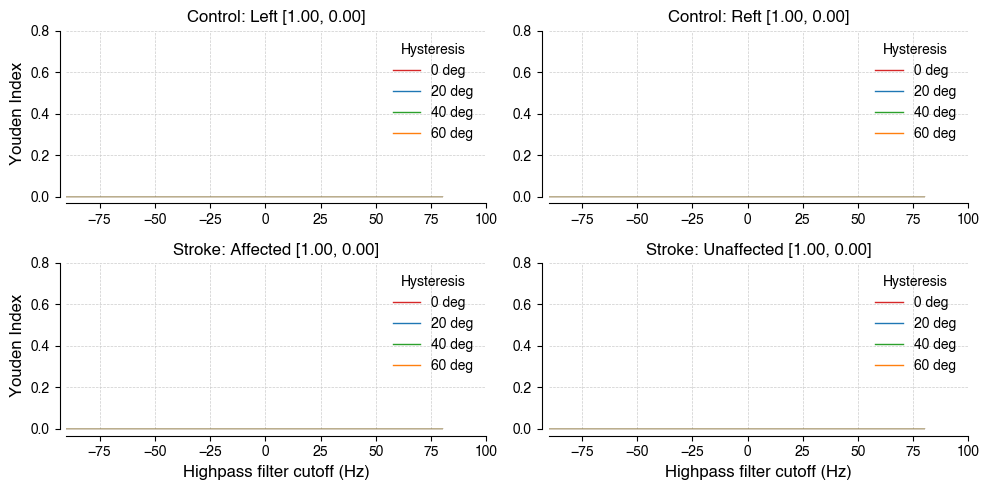

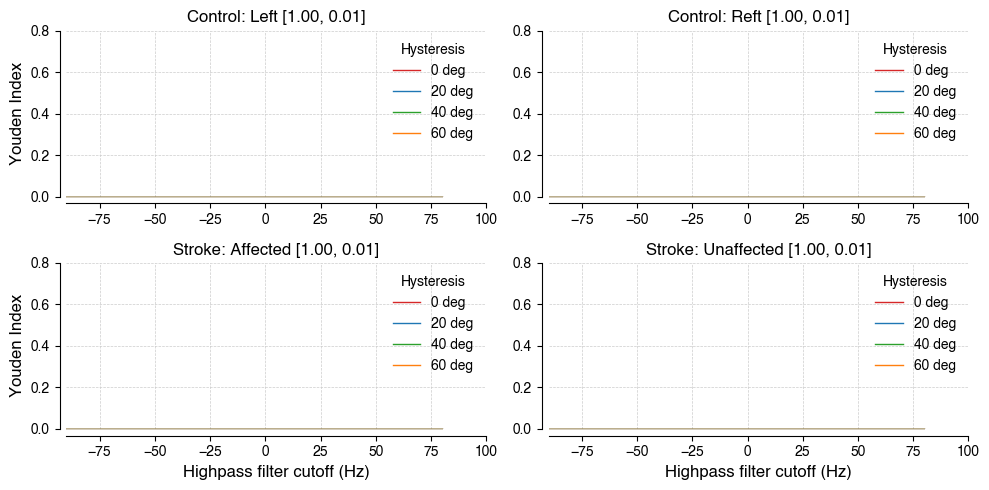

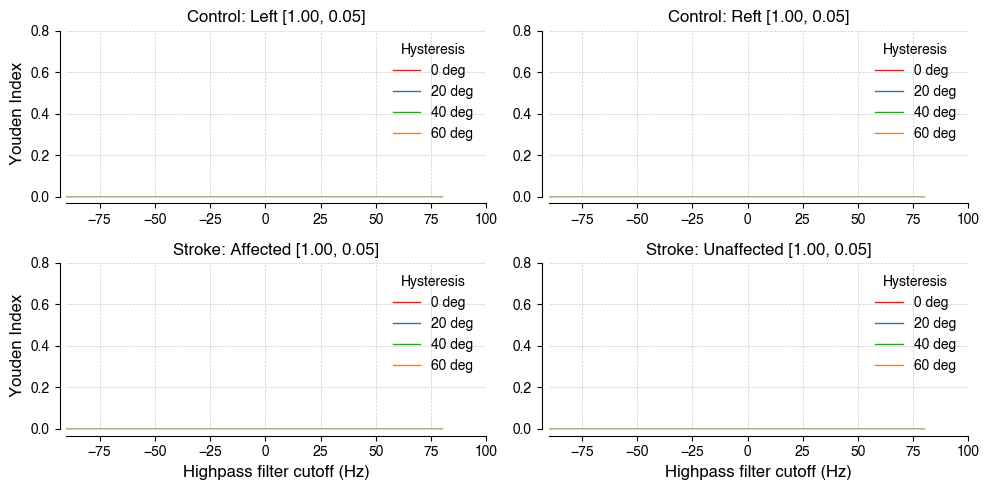

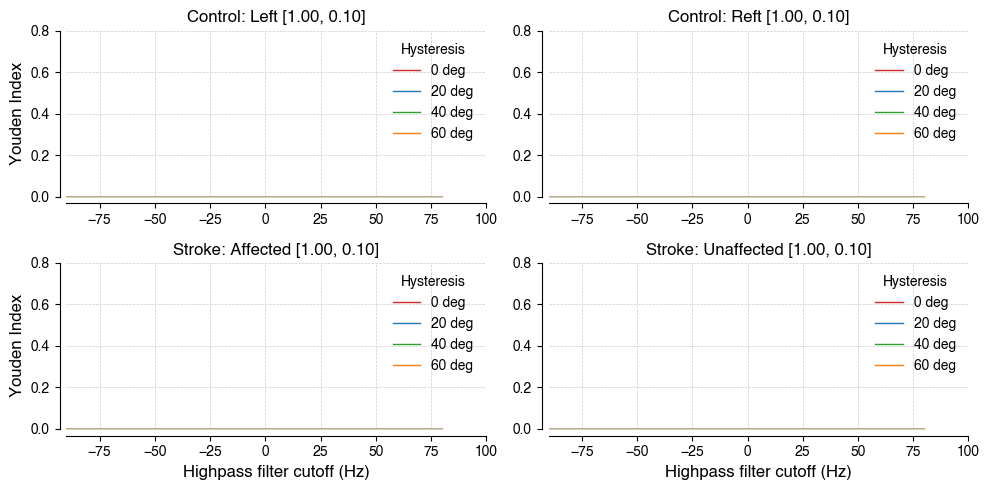

In [139]:
# Effect of pitch threshold.
for am_th in am_param_ranges["am_th"]:
    for am_th_b in am_param_ranges["am_th_band"]:
        fig = plt.figure(figsize=(10, 5))
        colors = ["tab:red", "tab:blue", "tab:green", "tab:orange", "tab:purple"]
        for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
            ax = fig.add_subplot(2, 2, j+1)
            for k, _pthbval in enumerate(am_param_ranges["p_th_band"]):
                # if k % 2 != 0:
                #     continue
                _yivals = []
                for i, _pval in enumerate(am_param_ranges["p_th"]):
                    _inx = ((gmac_perf_df[_lmb]["p_th"] == _pval) &
                            (gmac_perf_df[_lmb]["p_th_band"] == _pthbval) &
                            (gmac_perf_df[_lmb]["am_th"] == am_th) &
                            (gmac_perf_df[_lmb]["am_th_band"] == am_th_b))
                    _yi = gmac_perf_df[_lmb][_inx]["youden"].values
                    _yivals.append(np.nanpercentile(_yi, [25, 50, 75]))
                
                # Plot values.
                _yivals = np.array(_yivals).astype(float)
                ax.plot(am_param_ranges["p_th"], _yivals[:, 1], color=colors[k], lw=1,
                        label=f"{_pthbval} deg")
                ax.fill_between(x=am_param_ranges["p_th"], y1=_yivals[:, 0],
                                y2=_yivals[:, 2], color=colors[k], lw=0.5, alpha=0.1)
                ax.set_ylim(0.0, 0.8)
                ax.set_xlim(-90, 100)
                ax.grid(color='0.8', linestyle='--', linewidth=0.5);
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                ax.spines['left'].set_position(('outward', 5))
                ax.spines['bottom'].set_position(('outward', 5))
                ax.set_title(f"{_lmb}", fontsize=12)
                if _lmb == "left":
                    ax.set_title(f"Control: Left [{am_th:0.2f}, {am_th_b:0.2f}]", fontsize=12)
                elif _lmb == "right":
                    ax.set_title(f"Control: Reft [{am_th:0.2f}, {am_th_b:0.2f}]", fontsize=12)
                elif _lmb == "aff":
                    ax.set_title(f"Stroke: Affected [{am_th:0.2f}, {am_th_b:0.2f}]", fontsize=12)
                else:
                    ax.set_title(f"Stroke: Unaffected [{am_th:0.2f}, {am_th_b:0.2f}]", fontsize=12)
                
                if j // 2 == 1:
                    ax.set_xlabel("Highpass filter cutoff (Hz)", fontsize=12)
                if j % 2 == 0:
                    ax.set_ylabel("Youden Index", fontsize=12)
            _l = ax.legend(loc=1, fontsize=10, frameon=False)
            _l.set_title("Hysteresis")
            plt.tight_layout()

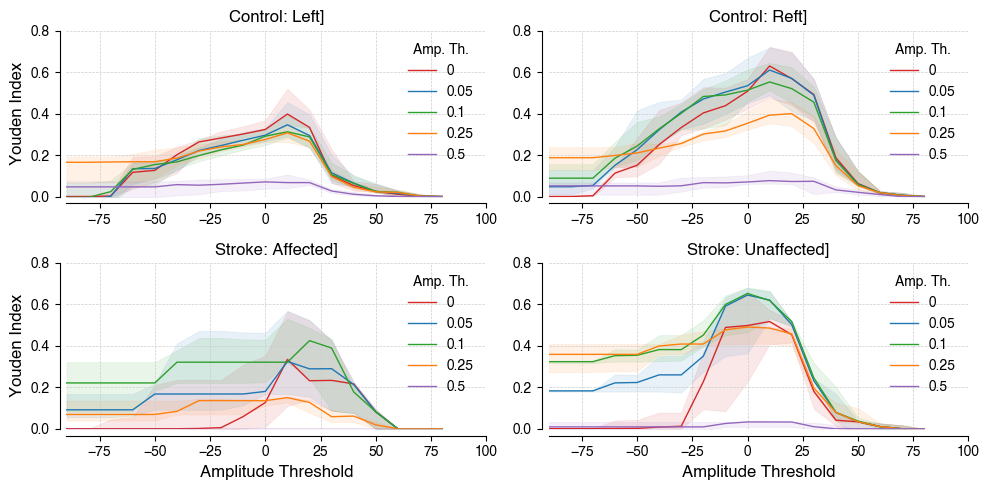

In [140]:
# Amplitude threshold versus pitch angle threshold
# for _amthb in am_param_ranges["am_th_band"]:
fig = plt.figure(figsize=(10, 5))
colors = ["tab:red", "tab:blue", "tab:green", "tab:orange", "tab:purple", "tab:brown", "tab:pink", "tab:gray"]
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 2, j+1)
    for k, _amth in enumerate([0, 0.05, 0.1, 0.25, 0.5]):
        # if k % 2 != 0:
        #     continue
        _yivals = []
        for i, _pval in enumerate(am_param_ranges["p_th"]):
            _inx = ((gmac_perf_df[_lmb]["p_th"] == _pval) &
                    (gmac_perf_df[_lmb]["p_th_band"] == 40) &
                    (gmac_perf_df[_lmb]["am_th"] == _amth) &
                    (gmac_perf_df[_lmb]["am_th_band"] == 0))
            _yi = gmac_perf_df[_lmb][_inx]["youden"].values
            _yivals.append(np.nanpercentile(_yi, [25, 50, 75]))
        
        # Plot values.
        _yivals = np.array(_yivals).astype(float)
        ax.plot(am_param_ranges["p_th"], _yivals[:, 1], color=colors[k], lw=1,
                label=f"{_amth}")
        ax.fill_between(x=am_param_ranges["p_th"], y1=_yivals[:, 0],
                        y2=_yivals[:, 2], color=colors[k], lw=0.5, alpha=0.1)
        ax.set_ylim(0.0, 0.8)
        ax.set_xlim(-90, 100)
        ax.grid(color='0.8', linestyle='--', linewidth=0.5);
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        ax.set_title(f"{_lmb}", fontsize=12)
        if _lmb == "left":
            ax.set_title(f"Control: Left]", fontsize=12)
        elif _lmb == "right":
            ax.set_title(f"Control: Reft]", fontsize=12)
        elif _lmb == "aff":
            ax.set_title(f"Stroke: Affected]", fontsize=12)
        else:
            ax.set_title(f"Stroke: Unaffected]", fontsize=12)
        
        if j // 2 == 1:
            ax.set_xlabel("Amplitude Threshold", fontsize=12)
        if j % 2 == 0:
            ax.set_ylabel("Youden Index", fontsize=12)
    _l = ax.legend(loc=1, fontsize=10, frameon=False)
    _l.set_title("Amp. Th.")
    
    plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "gmac_compare_ampth.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_compare_ampth.svg"), bbox_inches="tight")

### Summary plot

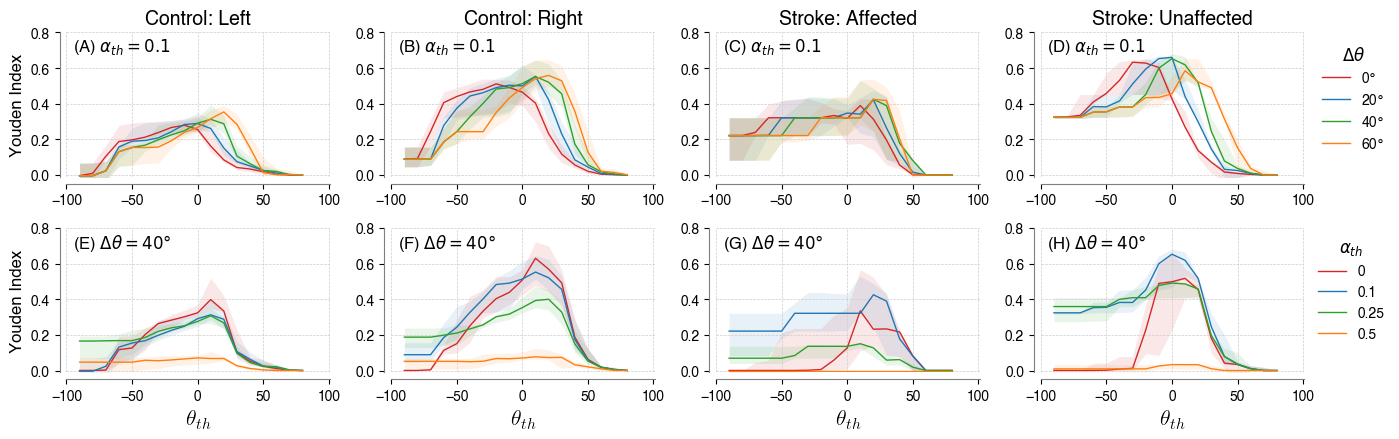

In [18]:
# Amplitude threshold versus pitch angle threshold
# for _amthb in am_param_ranges["am_th_band"]:
fig = plt.figure(figsize=(14, 4.5))
colors = ["tab:red", "tab:blue", "tab:green", "tab:orange", "tab:purple", "tab:brown", "tab:pink", "tab:gray"]
# Fixed amplitude
am_th = 0.1
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 4, j + 1)
    _txtflag = False
    for k, _pthb in enumerate(am_param_ranges["p_th_band"]):
        # if k % 2 != 0:
        #     continue
        _yivals = []
        for i, _pval in enumerate(am_param_ranges["p_th"]):
            _inx = ((gmac_perf_df[_lmb]["p_th"] == _pval) &
                    (gmac_perf_df[_lmb]["p_th_band"] == _pthb) &
                    (gmac_perf_df[_lmb]["am_th"] == am_th) &
                    (gmac_perf_df[_lmb]["am_th_band"] == 0))
            _yi = gmac_perf_df[_lmb][_inx]["youden"].values
            _yivals.append(np.nanpercentile(_yi, [25, 50, 75]))
        
        # Plot values.
        _yivals = np.array(_yivals).astype(float)
        ax.plot(am_param_ranges["p_th"], _yivals[:, 1], color=colors[k], lw=1,
                label=f"{_pthb}$\\degree$")
        ax.fill_between(x=am_param_ranges["p_th"], y1=_yivals[:, 0],
                        y2=_yivals[:, 2], color=colors[k], lw=0., alpha=0.1)
        ax.set_ylim(-0.01, 0.8)
        ax.set_xlim(-100, 101)
        ax.grid(color='0.8', linestyle='--', linewidth=0.5);
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        ax.spines['left'].set_color("tab:gray")
        ax.spines['bottom'].set_color("tab:gray")
        if _lmb == "left":
            ax.set_title(f"Control: Left", fontsize=14)
            if _txtflag is False:
                ax.text(0.025, 0.975, '(A) $\\alpha_{th} = 0.1$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        elif _lmb == "right":
            ax.set_title(f"Control: Right", fontsize=14)
            if _txtflag is False:
                ax.text(0.025, 0.975, '(B) $\\alpha_{th} = 0.1$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        elif _lmb == "aff":
            ax.set_title(f"Stroke: Affected", fontsize=14)
            if _txtflag is False:
                ax.text(0.025, 0.975, '(C) $\\alpha_{th} = 0.1$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        else:
            ax.set_title(f"Stroke: Unaffected", fontsize=14)
            if _txtflag is False:
                ax.text(0.025, 0.975, '(D) $\\alpha_{th} = 0.1$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        
        # ax.set_xlabel(r"$\theta_{th}$", fontsize=14, usetex=True)
        if j == 0:
            ax.set_ylabel("Youden Index", fontsize=12)
    
    if j == 3:
        # Legend to the right side of the plot
        _l = ax.legend(loc=1, fontsize=10, frameon=False, bbox_to_anchor=(1.35, 1.0))
        _l.set_title(r"$\Delta \theta$", prop={"size": 12})

# Fixed pitch band
p_th_band = 40
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 4, j + 5)
    _txtflag = False
    for k, _amth in enumerate([0, 0.1, 0.25, 0.5]):
        # if k % 2 != 0:
        #     continue
        _yivals = []
        for i, _pval in enumerate(am_param_ranges["p_th"]):
            _inx = ((gmac_perf_df[_lmb]["p_th"] == _pval) &
                    (gmac_perf_df[_lmb]["p_th_band"] == p_th_band) &
                    (gmac_perf_df[_lmb]["am_th"] == _amth) &
                    (gmac_perf_df[_lmb]["am_th_band"] == 0))
            _yi = gmac_perf_df[_lmb][_inx]["youden"].values
            _yivals.append(np.nanpercentile(_yi, [25, 50, 75]))
        
        # Plot values.
        _yivals = np.array(_yivals).astype(float)
        ax.plot(am_param_ranges["p_th"], _yivals[:, 1], color=colors[k], lw=1,
                label=f"{_amth}")
        ax.fill_between(x=am_param_ranges["p_th"], y1=_yivals[:, 0],
                        y2=_yivals[:, 2], color=colors[k], lw=0., alpha=0.1)
        ax.set_ylim(-0.01, 0.8)
        ax.set_xlim(-100, 101)
        ax.grid(color='0.8', linestyle='--', linewidth=0.5);
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        ax.spines['left'].set_color("tab:gray")
        ax.spines['bottom'].set_color("tab:gray")
        ax.set_xlabel(r"$\theta_{th}$", fontsize=16, usetex=True)
        if _lmb == "left":
            if _txtflag is False:
                ax.text(0.025, 0.975, f'(E) $\\Delta\\theta={p_th_band}\\degree$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        elif _lmb == "right":
            if _txtflag is False:
                ax.text(0.025, 0.975, f'(F) $\\Delta\\theta={p_th_band}\\degree$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        elif _lmb == "aff":
            if _txtflag is False:
                ax.text(0.025, 0.975, f'(G) $\\Delta\\theta={p_th_band}\\degree$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        else:
            if _txtflag is False:
                ax.text(0.025, 0.975, f'(H) $\\Delta\\theta={p_th_band}\\degree$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        if j == 0:
            ax.set_ylabel("Youden Index", fontsize=12)
    
    if j == 3:
        # Legend to the right side of the plot
        _l = ax.legend(loc=1, fontsize=10, frameon=False, bbox_to_anchor=(1.35, 1.0))
        _l.set_title(r"$\alpha_{th}$", prop={"size": 12})

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "gmac_compare.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_compare.svg"), bbox_inches="tight")

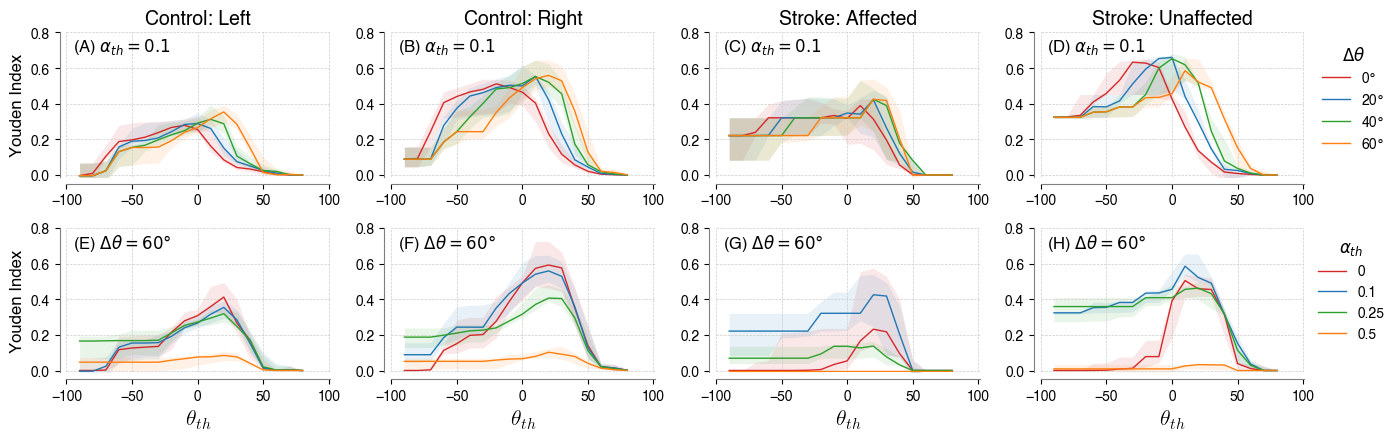

In [19]:
# Amplitude threshold versus pitch angle threshold
# for _amthb in am_param_ranges["am_th_band"]:
fig = plt.figure(figsize=(14, 4.5))
colors = ["tab:red", "tab:blue", "tab:green", "tab:orange", "tab:purple", "tab:brown", "tab:pink", "tab:gray"]
# Fixed amplitude
am_th = 0.1
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 4, j + 1)
    _txtflag = False
    for k, _pthb in enumerate(am_param_ranges["p_th_band"]):
        # if k % 2 != 0:
        #     continue
        _yivals = []
        for i, _pval in enumerate(am_param_ranges["p_th"]):
            _inx = ((gmac_perf_df[_lmb]["p_th"] == _pval) &
                    (gmac_perf_df[_lmb]["p_th_band"] == _pthb) &
                    (gmac_perf_df[_lmb]["am_th"] == am_th) &
                    (gmac_perf_df[_lmb]["am_th_band"] == 0))
            _yi = gmac_perf_df[_lmb][_inx]["youden"].values
            _yivals.append(np.nanpercentile(_yi, [25, 50, 75]))
        
        # Plot values.
        _yivals = np.array(_yivals).astype(float)
        ax.plot(am_param_ranges["p_th"], _yivals[:, 1], color=colors[k], lw=1,
                label=f"{_pthb}$\\degree$")
        ax.fill_between(x=am_param_ranges["p_th"], y1=_yivals[:, 0],
                        y2=_yivals[:, 2], color=colors[k], lw=0., alpha=0.1)
        ax.set_ylim(-0.01, 0.8)
        ax.set_xlim(-100, 101)
        ax.grid(color='0.8', linestyle='--', linewidth=0.5);
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        ax.spines['left'].set_color("tab:gray")
        ax.spines['bottom'].set_color("tab:gray")
        if _lmb == "left":
            ax.set_title(f"Control: Left", fontsize=14)
            if _txtflag is False:
                ax.text(0.025, 0.975, '(A) $\\alpha_{th} = 0.1$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        elif _lmb == "right":
            ax.set_title(f"Control: Right", fontsize=14)
            if _txtflag is False:
                ax.text(0.025, 0.975, '(B) $\\alpha_{th} = 0.1$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        elif _lmb == "aff":
            ax.set_title(f"Stroke: Affected", fontsize=14)
            if _txtflag is False:
                ax.text(0.025, 0.975, '(C) $\\alpha_{th} = 0.1$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        else:
            ax.set_title(f"Stroke: Unaffected", fontsize=14)
            if _txtflag is False:
                ax.text(0.025, 0.975, '(D) $\\alpha_{th} = 0.1$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        
        # ax.set_xlabel(r"$\theta_{th}$", fontsize=14, usetex=True)
        if j == 0:
            ax.set_ylabel("Youden Index", fontsize=12)
    
    if j == 3:
        # Legend to the right side of the plot
        _l = ax.legend(loc=1, fontsize=10, frameon=False, bbox_to_anchor=(1.35, 1.0))
        _l.set_title(r"$\Delta \theta$", prop={"size": 12})

# Fixed pitch band
p_th_band = 60
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 4, j + 5)
    _txtflag = False
    for k, _amth in enumerate([0, 0.1, 0.25, 0.5]):
        # if k % 2 != 0:
        #     continue
        _yivals = []
        for i, _pval in enumerate(am_param_ranges["p_th"]):
            _inx = ((gmac_perf_df[_lmb]["p_th"] == _pval) &
                    (gmac_perf_df[_lmb]["p_th_band"] == p_th_band) &
                    (gmac_perf_df[_lmb]["am_th"] == _amth) &
                    (gmac_perf_df[_lmb]["am_th_band"] == 0))
            _yi = gmac_perf_df[_lmb][_inx]["youden"].values
            _yivals.append(np.nanpercentile(_yi, [25, 50, 75]))
        
        # Plot values.
        _yivals = np.array(_yivals).astype(float)
        ax.plot(am_param_ranges["p_th"], _yivals[:, 1], color=colors[k], lw=1,
                label=f"{_amth}")
        ax.fill_between(x=am_param_ranges["p_th"], y1=_yivals[:, 0],
                        y2=_yivals[:, 2], color=colors[k], lw=0., alpha=0.1)
        ax.set_ylim(-0.01, 0.8)
        ax.set_xlim(-100, 101)
        ax.grid(color='0.8', linestyle='--', linewidth=0.5);
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        ax.spines['left'].set_color("tab:gray")
        ax.spines['bottom'].set_color("tab:gray")
        ax.set_xlabel(r"$\theta_{th}$", fontsize=16, usetex=True)
        if _lmb == "left":
            if _txtflag is False:
                ax.text(0.025, 0.975, f'(E) $\\Delta\\theta={p_th_band}\\degree$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        elif _lmb == "right":
            if _txtflag is False:
                ax.text(0.025, 0.975, f'(F) $\\Delta\\theta={p_th_band}\\degree$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        elif _lmb == "aff":
            if _txtflag is False:
                ax.text(0.025, 0.975, f'(G) $\\Delta\\theta={p_th_band}\\degree$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        else:
            if _txtflag is False:
                ax.text(0.025, 0.975, f'(H) $\\Delta\\theta={p_th_band}\\degree$', fontsize=12,
                        horizontalalignment='left', verticalalignment='top',
                        transform=ax.transAxes)
                _txtflag = True
        if j == 0:
            ax.set_ylabel("Youden Index", fontsize=12)
    
    if j == 3:
        # Legend to the right side of the plot
        _l = ax.legend(loc=1, fontsize=10, frameon=False, bbox_to_anchor=(1.35, 1.0))
        _l.set_title(r"$\alpha_{th}$", prop={"size": 12})

plt.tight_layout()

# fig.savefig(pathlib.Path(basedir, "gmac_compare.pdf"), bbox_inches="tight")
# fig.savefig(pathlib.Path(basedir, "gmac_compare.svg"), bbox_inches="tight")


## Comparison with old GMAC

#### Compute the Old GMAC measure

In [15]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

# All limbs data ddf
datadf = {
    "left": left,
    "right": right,
    "aff": aff,
    "unaff": unaff
}

In [16]:
# Old GMAC Df
dfcols = ["subject", "vm", "pitch", "gmac", "gt"]
old_gmac_df = {}
for limb in ['left', 'right', 'aff', 'unaff']:
    old_gmac_df[limb] = pd.DataFrame(columns=dfcols)
    # Which limb?
    limbdf = datadf[limb]
    subjects = limbdf.subject.unique()
    _subjdf = pd.DataFrame(columns=dfcols)
    for subj in subjects:
        # Go through all parameter combinations.
        _sinx = limbdf.subject == subj
        # Compute the vector magnitude
        _vmdf = misc.compute_vector_magnitude(limbdf[_sinx])
        # Compute mean pitch
        _pthdf = limbdf[_sinx]['pitch'].resample(str(1) + 'S').mean()
        # Ground truth
        _gtdf = (limbdf[_sinx]['gnd'].resample(str(1) + 'S').mean() > 0.5).astype(int)
        # Update datarame
        _tempdf = pd.merge(_pthdf, _gtdf, left_index=True, right_index=True)
        _tempdf = pd.merge(_tempdf, _vmdf, left_index=True, right_index=True)
        _tempdf = _tempdf.rename(columns={'counts': 'ac', "gnd": "gt"})
        _tempdf['subject'] = subj
        _tempdf['gmac'] = (_tempdf['ac'] > 0) & (np.abs(_tempdf['pitch']) < 30)
        _tempdf['gmac'] = _tempdf['gmac'].astype(int)
        # Update subject df.
        _subjdf = pd.concat((_subjdf, _tempdf), ignore_index=True)
    old_gmac_df[limb] = _subjdf

In [17]:
# Compute performance
dfcols =["subject", "TN", "FP", "FN", "TP",
         "TNr", "FPr", "FNr", "TPr",
         "sensitivity", "specificity", "youden"]

old_gmac_perf_df = {}

# Old GMAC Df
for limb in ['left', 'right', 'aff', 'unaff']:
    old_gmac_perf_df[limb] = pd.DataFrame(columns=dfcols)
    # Which limb?
    limbdf = old_gmac_df[limb]
    subjects = limbdf.subject.unique()
    _subjdf = pd.DataFrame(columns=dfcols)
    for subj in subjects:
        # Go through all parameter combinations.
        _sinx = limbdf.subject == subj
        # Compute performance
        _perf = compute_confusion_matrix(actual=limbdf[_sinx]['gt'].values,
                                         estimated=limbdf[_sinx]['gmac'].values)
        # Update gmac df
        _rowdf = pd.DataFrame({"subject": subj} | _perf, index=[0])
        _rowdf[["TNr", "FPr", "FNr", "TPr"]] = _rowdf[["TN", "FP", "FN", "TP"]] / np.sum(_rowdf[["TN", "FP", "FN", "TP"]].values)
        _rowdf["sensitivity"] = _rowdf.TP / (_rowdf.TP + _rowdf.FN)
        _rowdf["specificity"] = _rowdf.TN / (_rowdf.TN + _rowdf.FP)
        _rowdf["youden"] = _rowdf.sensitivity + _rowdf.specificity - 1
        _subjdf = pd.concat((_subjdf, _rowdf), ignore_index=True)
    old_gmac_perf_df[limb] = _subjdf

In [18]:
limb = "left"
pc_combs = [
    [0.1, 0, 40],
    [0.1, 10, 40],
    [0.1, 20, 40],
]
_inx = [
    (gmac_perf_df[limb]["am_th"] == pc_combs[i][0]) &
    (gmac_perf_df[limb]["am_th_band"] == 0) &
    (gmac_perf_df[limb]["p_th"] == pc_combs[i][1]) &
    (gmac_perf_df[limb]["p_th_band"] == pc_combs[i][2])
    for i in range(3)
]

# Limbs
limbs = ["left", "right", "aff", "unaff"]
perf_compare = {
    "youden": [[] for _ in limbs],
    "sensitivity": [[] for _ in limbs],
    "specificity": [[] for _ in limbs],
}
for i, limb in enumerate(limbs):
    for j in range(3):
        _inx = ((gmac_perf_df[limb]["am_th"] == pc_combs[j][0]) &
                (gmac_perf_df[limb]["am_th_band"] == 0) &
                (gmac_perf_df[limb]["p_th"] == pc_combs[j][1]) &
                (gmac_perf_df[limb]["p_th_band"] == pc_combs[j][2]))
        perf_compare["youden"][i].append(gmac_perf_df[limb][_inx]["youden"].values)
        perf_compare["sensitivity"][i].append(gmac_perf_df[limb][_inx]["sensitivity"].values)
        perf_compare["specificity"][i].append(gmac_perf_df[limb][_inx]["specificity"].values)
    perf_compare["youden"][i].append(old_gmac_perf_df[limb]["youden"].values)
    perf_compare["sensitivity"][i].append(old_gmac_perf_df[limb]["sensitivity"].values)
    perf_compare["specificity"][i].append(old_gmac_perf_df[limb]["specificity"].values)


In [19]:
from matplotlib import gridspec

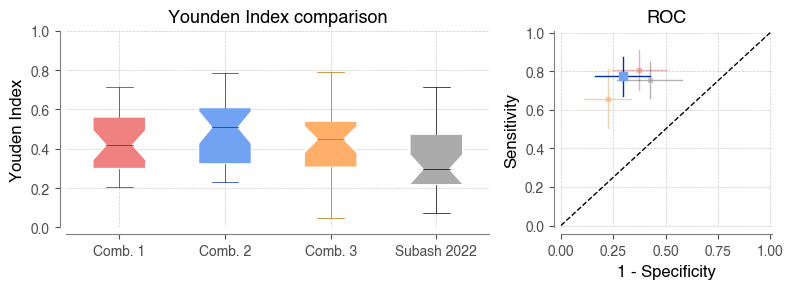

In [26]:
# Combine data from all limbs
colors1 = ["#f08181", "#72a3f2", "#ffaf69", "#ababab"]
colors2 = ["#a80a0a", "#002eab", "#bd6e00", "black"]
fig = plt.figure(figsize=(8, 3))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[2, 1])
ax = plt.subplot(gs[0, 0])
for j in range(4):
    _vals = np.hstack([perf_compare["youden"][i][j] for i in range(4)])
    ax.boxplot(x=_vals, positions=[j],
            widths=0.5, notch=True, patch_artist=True,
            boxprops=dict(facecolor=colors1[j], color=[1, 1, 1], alpha=1.0),
            capprops=dict(color=colors2[j], alpha=1.0, lw=0.5),
            whiskerprops=dict(color=colors2[j], alpha=1.0, lw=0.5),
            flierprops=dict(color=colors2[j], markeredgecolor=colors2[j],
                            markerfacecolor=colors2[j], marker='+', markersize=4),
            medianprops=dict(color=colors2[j], alpha=1.0, lw=0.5))
    ax.set_ylim(0.0, 1.0)
    ax.set_xlim(-0.5, 3.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_color("tab:gray")
    ax.spines['bottom'].set_color("tab:gray")
    ax.tick_params(axis='x', colors='0.3')
    ax.tick_params(axis='y', colors='0.3')
    ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xticklabels(
    [f"Comb. {i+1}" for i in range(3)] + ["Subash 2022"]
)
# ax.set_xticklabels(
#     [r"$\alpha_{th}=$" + f"{pc_combs[i][0]}\n" +
#      r"$\theta_{th}=$" + f"{pc_combs[i][1]}" + r"$^\circ$" + "\n"
#      r"$\Delta\theta=$" + f"{pc_combs[i][2]}" + r"$^\circ$"
#      for i in range(3)] + ["Subash 2022\n et.al"]
# )
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# PC 3
_valsens = np.hstack([perf_compare["sensitivity"][i][2] for i in range(4)])
_valspec = np.hstack([perf_compare["specificity"][i][2] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - _xstd, 1 - _xmean + _xstd],
        [_ymean, _ymean], color=colors2[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - _ystd, _ymean + _ystd], color=colors2[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=3, color=colors1[2], alpha=0.5)
# PC 1
_valsens = np.hstack([perf_compare["sensitivity"][i][0] for i in range(4)])
_valspec = np.hstack([perf_compare["specificity"][i][0] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - _xstd, 1 - _xmean + _xstd],
        [_ymean, _ymean], color=colors2[0], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - _ystd, _ymean + _ystd], color=colors2[0], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=3, color=colors1[0], alpha=0.5)
# Old GMAC
_valsens = np.hstack([perf_compare["sensitivity"][i][3] for i in range(4)])
_valspec = np.hstack([perf_compare["specificity"][i][3] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - _xstd, 1 - _xmean + _xstd],
        [_ymean, _ymean], color=colors2[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - _ystd, _ymean + _ystd], color=colors2[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=3, color=colors1[3], alpha=0.5)
# PC 2
_valsens = np.hstack([perf_compare["sensitivity"][i][1] for i in range(4)])
_valspec = np.hstack([perf_compare["specificity"][i][1] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - _xstd, 1 - _xmean + _xstd],
        [_ymean, _ymean], color=colors2[1], alpha=1, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - _ystd, _ymean + _ystd], color=colors2[1], alpha=1, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=colors1[1])
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "gmac_summary.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_summary.svg"), bbox_inches="tight")

### Pairwise comparison of the Younden indices with Subash 2022 results

In [47]:
from scipy import stats

#### Comparing the Youden Index

In [85]:
# Limbs
limbs = ["left", "right", "aff", "unaff"]
diff_perf = [[[], []],
             [[], []],
             [[], []]]
for i, limb in enumerate(limbs):
    for j in range(3):
        _inx = ((gmac_perf_df[limb]["am_th"] == pc_combs[j][0]) &
                (gmac_perf_df[limb]["am_th_band"] == 0) &
                (gmac_perf_df[limb]["p_th"] == pc_combs[j][1]) &
                (gmac_perf_df[limb]["p_th_band"] == pc_combs[j][2]))
        for subj in gmac_perf_df[limb]["subject"].unique():
            _sinx = (gmac_perf_df[limb]["subject"] == subj)
            _sinxold = (old_gmac_perf_df[limb]["subject"] == subj)
            _youden = gmac_perf_df[limb][_inx & _sinx]["youden"].values[0]
            diff_perf[j][0].append(_youden)
            diff_perf[j][1].append(old_gmac_perf_df[limb][_sinxold]["youden"].values[0])

In [86]:
# Perform paired t-tests
p_values = []
for i in range(3):
    t_stat, p_val = stats.ttest_rel(diff_perf[i][0], diff_perf[i][1])
    p_values.append((i, t_stat, p_val))

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05
adjusted_alpha = alpha / len(p_values)

for i, t_stat, p_val in p_values:
    if p_val < adjusted_alpha:
        print(f"Pairwise comparison for combination {i + 1} is statistically significant.")

Pairwise comparison for combination 1 is statistically significant.
Pairwise comparison for combination 2 is statistically significant.
Pairwise comparison for combination 3 is statistically significant.


In [87]:
p_values

[(0, 6.12333579503023, 1.1361749553517926e-06),
 (1, 8.17135433293756, 5.203534861502115e-09),
 (2, 4.261015907249324, 0.0001961286317340606)]

In [88]:
for i in range(3):
    _diff = np.array(diff_perf[i][0]) - np.array(diff_perf[i][1])
    print(i, np.mean(_diff), np.std(_diff))

0 0.09847208074870907 0.08660122545682426
1 0.14633749171157512 0.0964407463219394
2 0.10083461696289546 0.12743698742960347


#### Comparing the Sensitivity

In [89]:
# Limbs
limbs = ["left", "right", "aff", "unaff"]
diff_perf = [[[], []],
             [[], []],
             [[], []]]
for i, limb in enumerate(limbs):
    for j in range(3):
        _inx = ((gmac_perf_df[limb]["am_th"] == pc_combs[j][0]) &
                (gmac_perf_df[limb]["am_th_band"] == 0) &
                (gmac_perf_df[limb]["p_th"] == pc_combs[j][1]) &
                (gmac_perf_df[limb]["p_th_band"] == pc_combs[j][2]))
        for subj in gmac_perf_df[limb]["subject"].unique():
            _sinx = (gmac_perf_df[limb]["subject"] == subj)
            _sinxold = (old_gmac_perf_df[limb]["subject"] == subj)
            _youden = gmac_perf_df[limb][_inx & _sinx]["sensitivity"].values[0]
            diff_perf[j][0].append(_youden)
            diff_perf[j][1].append(old_gmac_perf_df[limb][_sinxold]["sensitivity"].values[0])

In [90]:
# Perform paired t-tests
p_values = []
for i in range(3):
    t_stat, p_val = stats.ttest_rel(diff_perf[i][0], diff_perf[i][1])
    p_values.append((i, t_stat, p_val))

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05
adjusted_alpha = alpha / len(p_values)

for i, t_stat, p_val in p_values:
    print(p_val, adjusted_alpha)
    if p_val < adjusted_alpha:
        print(f"Pairwise comparison for combination {i + 1} is statistically significant.")

0.003154211407811982 0.016666666666666666
Pairwise comparison for combination 1 is statistically significant.
0.33083439836043904 0.016666666666666666
0.004785182953842392 0.016666666666666666
Pairwise comparison for combination 3 is statistically significant.


In [91]:
p_values

[(0, 3.21984886400287, 0.003154211407811982),
 (1, 0.9890192459000562, 0.33083439836043904),
 (2, -3.0555434079478134, 0.004785182953842392)]

In [92]:
for i in range(3):
    _diff = np.array(diff_perf[i][0]) - np.array(diff_perf[i][1])
    print(i, np.mean(_diff), np.std(_diff))

0 0.05035074204703836 0.08421110913502083
1 0.017800833105127745 0.09692472656401246
2 -0.09836984866720919 0.17336943921264347


#### Comparing the Specificity

In [93]:
# Limbs
limbs = ["left", "right", "aff", "unaff"]
diff_perf = [[[], []],
             [[], []],
             [[], []]]
for i, limb in enumerate(limbs):
    for j in range(3):
        _inx = ((gmac_perf_df[limb]["am_th"] == pc_combs[j][0]) &
                (gmac_perf_df[limb]["am_th_band"] == 0) &
                (gmac_perf_df[limb]["p_th"] == pc_combs[j][1]) &
                (gmac_perf_df[limb]["p_th_band"] == pc_combs[j][2]))
        for subj in gmac_perf_df[limb]["subject"].unique():
            _sinx = (gmac_perf_df[limb]["subject"] == subj)
            _sinxold = (old_gmac_perf_df[limb]["subject"] == subj)
            _youden = gmac_perf_df[limb][_inx & _sinx]["specificity"].values[0]
            diff_perf[j][0].append(_youden)
            diff_perf[j][1].append(old_gmac_perf_df[limb][_sinxold]["specificity"].values[0])

In [94]:
# Perform paired t-tests
p_values = []
for i in range(3):
    t_stat, p_val = stats.ttest_rel(diff_perf[i][0], diff_perf[i][1])
    p_values.append((i, t_stat, p_val))

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05
adjusted_alpha = alpha / len(p_values)

for i, t_stat, p_val in p_values:
    if p_val < adjusted_alpha:
        print(f"Pairwise comparison for combination {i + 1} is statistically significant.")

Pairwise comparison for combination 1 is statistically significant.
Pairwise comparison for combination 2 is statistically significant.
Pairwise comparison for combination 3 is statistically significant.


In [95]:
p_values

[(0, 3.0296526031986706, 0.005106285920704413),
 (1, 6.5677263014346785, 3.398774628416974e-07),
 (2, 7.945144380262716, 9.207316345999467e-09)]

In [96]:
for i in range(3):
    _diff = np.array(diff_perf[i][0]) - np.array(diff_perf[i][1])
    print(i, np.mean(_diff), np.std(_diff))

0 0.048121338701670714 0.08553500139746664
1 0.12853665860644742 0.10539280393016655
2 0.1992044656301046 0.1350194315411298


## Optimizing AC rule alone

In [101]:
print(datadf["left"]["pitch"].min(), datadf["left"]["pitch"].max())
print(datadf["right"]["pitch"].min(), datadf["right"]["pitch"].max())
print(datadf["aff"]["pitch"].min(), datadf["aff"]["pitch"].max())
print(datadf["unaff"]["pitch"].min(), datadf["unaff"]["pitch"].max())

-89.8441872592712 88.30559330906428
-89.36764625417625 82.64086933948765
-87.80765458037027 60.63228543706746
-88.21202735717013 89.27260153668728


In [113]:
# Lowest possible thresholds for pitch. Ensure the pitch rule is always True.
p_th = -90
p_th_band = 0
selcols = ["subject", "sensitivity", "specificity", "youden", "am_th", "am_th_band"]
am_perf_df = {}
for limb in ["left", "right", "aff", "unaff"]:
    am_perf_df[limb] = pd.DataFrame(columns=selcols)
    for _amth in am_param_ranges["am_th"]:
        for _amthb in am_param_ranges["am_th_band"]:
            _inx = ((gmac_perf_df[limb]["am_th"] == _amth) &
                    (gmac_perf_df[limb]["am_th_band"] == _amthb) &
                    (gmac_perf_df[limb]["p_th"] == p_th) &
                    (gmac_perf_df[limb]["p_th_band"] == p_th_band))
            _perf = gmac_perf_df[limb][_inx][selcols].values
            am_perf_df[limb] = pd.concat((am_perf_df[limb],
                                          pd.DataFrame(_perf, columns=selcols)),
                                         ignore_index=True) 
    am_perf_df[limb]["subject"] = am_perf_df[limb]["subject"].astype(int)

In [107]:
datadf["left"]

ax        ay        az        gx        gy  \
time                                                                        
2020-03-11 12:18:34.340 -0.704590  0.613770  0.076172 -1.062537  0.340931   
2020-03-11 12:18:34.360 -0.726074  0.502930  0.105957 -0.744334  0.256857   
2020-03-11 12:18:34.380 -0.777832  0.334473  0.094238 -0.488919  0.146178   
2020-03-11 12:18:34.400 -0.673340  0.317871  0.085938 -0.636315  0.138728   
2020-03-11 12:18:34.420 -0.707031  0.235840  0.021484 -0.703893  0.138728   
...                           ...       ...       ...       ...       ...   
2020-03-11 17:05:57.340 -0.986328  0.279297 -0.169922  2.399092  0.133895   
2020-03-11 17:05:57.360 -1.002441  0.288574 -0.165039  2.135696  0.076427   
2020-03-11 17:05:57.380 -1.028809  0.251953 -0.150391  1.918062  0.008316   
2020-03-11 17:05:57.400 -1.051758  0.231445 -0.149414  1.786630 -0.060326   
2020-03-11 17:05:57.420 -1.061035  0.196777 -0.106445  1.714794 -0.112473   

                               gz      pitch         yaw         mx  \
time                                                                  
2020-03-11 12:18:34.340 -0.282356 -10.199455  420.072372  -0.601504   
2020-03-11 12:18:34.360 -0.363769 -11.286190  422.220091   1.503759   
2020-03-11 12:18:34.380 -0.474980 -12.418367  421.396061   1.203008   
2020-03-11 12:18:34.400 -0.707514 -13.778245  420.937020   0.751880   
2020-03-11 12:18:34.420 -0.821918 -15.278585  421.524763   1.654135   
...                           ...        ...         ...        ...   
2020-03-11 17:05:57.340  1.044005 -65.804344  -37.658589  27.819549   
2020-03-11 17:05:57.360  1.179694 -65.406411  -39.880631  27.669173   
2020-03-11 17:05:57.380  1.299419 -64.989330  -42.844846  26.466165   
2020-03-11 17:05:57.400  1.378172 -64.572561  -44.946406  28.421053   
2020-03-11 17:05:57.420  1.404777 -64.166509  -47.077497  28.120301   

                                my  ...  subject                 old_time r1  \
time                                ...                                        
2020-03-11 12:18:34.340  52.180451  ...        2  2020-03-11 12:18:33.620  0   
2020-03-11 12:18:34.360  53.383459  ...        2  2020-03-11 12:18:33.640  0   
2020-03-11 12:18:34.380  52.631579  ...        2  2020-03-11 12:18:33.660  0   
2020-03-11 12:18:34.400  50.526316  ...        2  2020-03-11 12:18:33.680  0   
2020-03-11 12:18:34.420  52.781955  ...        2  2020-03-11 12:18:33.700  0   
...                            ...  ...      ...                      ... ..   
2020-03-11 17:05:57.340  64.060150  ...        1  2020-03-11 17:05:56.080  0   
2020-03-11 17:05:57.360  66.015038  ...        1  2020-03-11 17:05:56.100  0   
2020-03-11 17:05:57.380  66.315789  ...        1  2020-03-11 17:05:56.120  0   
2020-03-11 17:05:57.400  66.466165  ...        1  2020-03-11 17:05:56.140  0   
2020-03-11 17:05:57.420  68.270677  ...        1  2020-03-11 17:05:56.160  0   

                         r2  g1  g2  task use_type gnd  segment  
time                                                             
2020-03-11 12:18:34.340   0   0   0                  0        0  
2020-03-11 12:18:34.360   0   0   0                  0        0  
2020-03-11 12:18:34.380   0   0   0                  0        0  
2020-03-11 12:18:34.400   0   0   0                  0        0  
2020-03-11 12:18:34.420   0   0   0                  0        0  
...                      ..  ..  ..   ...      ...  ..      ...  
2020-03-11 17:05:57.340   0   0   0                  0        1  
2020-03-11 17:05:57.360   0   0   0                  0        1  
2020-03-11 17:05:57.380   0   0   0                  0        1  
2020-03-11 17:05:57.400   0   0   0                  0        1  
2020-03-11 17:05:57.420   0   0   0                  0        1  

[245012 rows x 21 columns]